# SECOM Yield Prediction — End-to-End Notebook

**Goal:** Predict *Fail* outcomes from process measurements to reduce scrap and downtime.

**Data:** `data/secom.data`, `data/secom_labels.data`, `data/secom.names` (UCI ML Repository, real fab data).

**Primary metric:** Recall on *Fail* at acceptable precision. Report PR-AUC and Balanced Error Rate (BER).

### 1. Setup

In [1]:
# Basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib


# Global style for plots
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.color": "black",
    "ytick.color": "black",
    "xtick.direction": "out",
    "ytick.direction": "out",
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.top": False,
    "ytick.right": False,
    "figure.dpi": 150,
    "legend.frameon": True,
    "legend.facecolor": "white",
    "legend.edgecolor": "black",
    "legend.fontsize": 12
})

# Apply to seaborn
sns.set_theme(context="notebook", style="ticks")

# Reproducibility
rnd_num = 42
rng = np.random.seed(rnd_num)

# Root directory
ROOT = Path(os.getcwd()).parent

# Data directory
DATA_DIR = Path(ROOT/"data")
RAW = Path(DATA_DIR/"raw")
assert (RAW/"secom.data").exists() and (RAW/"secom_labels.data").exists(), "Data files are missing!"

# Results directory
RESULT_DIR = Path(ROOT/"results")
RESULT_DIR.mkdir(exist_ok=True, parents=True)

# Model directory
MODEL_DIR = Path(ROOT/"models")
MODEL_DIR.mkdir(exist_ok=True, parents=True)

In [2]:
# Figure saver helper (use after each plot)
RESULT_DIR_AR = Path(RESULT_DIR/"advanced_research")
RESULT_DIR_AR.mkdir(exist_ok=True, parents=True)
def savefig(name):
    out = RESULT_DIR_AR/name
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")
    print("Saved:", out)

### 2. Libraries

In [3]:
# Libraries
import torch
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import brier_score_loss, average_precision_score, roc_auc_score
from sklearn.calibration import calibration_curve

from sklearn.metrics import (precision_recall_curve, average_precision_score,
                             roc_auc_score, balanced_accuracy_score,
                             confusion_matrix, classification_report,
                             brier_score_loss, roc_curve)

### 3. Load data from 04_Interpretability.ipynb

In [4]:
ART  = ROOT/"artifacts"

splits   = joblib.load(ART/"data_splits.joblib")
feat_cols = splits["feat_cols"]
Xva, yva, Xte, yte = splits["Xva"], splits["yva"], splits["Xte"], splits["yte"]

test_probs = joblib.load(ART/"test_probs.joblib")    # model -> p_test
val_probs  = joblib.load(ART/"val_probs.joblib")     # model -> p_val
ths        = joblib.load(ART/"thresholds.joblib")    # dicts: thr_f1, thr_r10
thr_f1, thr_r10 = ths["thr_f1"], ths["thr_r10"]

# Optional artifacts
shap_topk   = joblib.load(ART/"shap_topk.joblib") if (ART/"shap_topk.joblib").exists() else {}
df_cost     = joblib.load(ART/"cost_sweep_df.joblib") if (ART/"cost_sweep_df.joblib").exists() else None
df_boot     = joblib.load(ART/"bootstrap_df.joblib") if (ART/"bootstrap_df.joblib").exists() else None

print("Loaded:", list(test_probs.keys()))

Loaded: ['Logistic', 'RandomForest', 'XGBoost', 'FeatureSel (best pipe)', 'MLP', 'Stacking (meta)']


In [5]:
# keep only models present in both val & test and with thresholds
common = set(test_probs) & set(val_probs) & set(thr_f1) & set(thr_r10)
test_probs = {k: test_probs[k] for k in common}
val_probs  = {k: val_probs[k]  for k in common}
thr_f1     = {k: thr_f1[k]     for k in common}
thr_r10    = {k: thr_r10[k]    for k in common}
print("Models in scope:", sorted(common))

Models in scope: ['FeatureSel (best pipe)', 'Logistic', 'MLP', 'RandomForest', 'Stacking (meta)', 'XGBoost']


### 1. Isotonic calibration.

In [6]:
# --- fit isotonic per model on validation ---
def _fit_iso(y_val, p_val):
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(np.asarray(p_val, float), np.asarray(y_val, int))
    return iso

def _basic_scores(y, p):
    return dict(
        Brier=brier_score_loss(y, p),
        PR_AUC=average_precision_score(y, p),
        ROC_AUC=roc_auc_score(y, p),
    )

iso_maps       = {}   # model -> IsotonicRegression
cal_val_probs  = {}   # model -> calibrated p_val
cal_test_probs = {}   # model -> calibrated p_test
rows = []

for model in sorted(test_probs.keys()):
    p_val  = np.asarray(val_probs[model],  dtype=float)
    p_test = np.asarray(test_probs[model], dtype=float)

    iso = _fit_iso(yva, p_val)
    iso_maps[model] = iso

    p_val_iso  = iso.predict(p_val)
    p_test_iso = iso.predict(p_test)
    cal_val_probs[model]  = p_val_iso
    cal_test_probs[model] = p_test_iso

    m_val_raw = _basic_scores(yva, p_val)
    m_val_iso = _basic_scores(yva, p_val_iso)
    m_te_raw  = _basic_scores(yte, p_test)
    m_te_iso  = _basic_scores(yte, p_test_iso)

    rows.append({
        "Model": model, "Calibrator": "isotonic",
        "Brier_VAL_raw": m_val_raw["Brier"], "Brier_VAL_cal": m_val_iso["Brier"],
        "PRAUC_VAL_raw": m_val_raw["PR_AUC"], "PRAUC_VAL_cal": m_val_iso["PR_AUC"],
        "ROCAUC_VAL_raw": m_val_raw["ROC_AUC"], "ROCAUC_VAL_cal": m_val_iso["ROC_AUC"],
        "Brier_TEST_raw": m_te_raw["Brier"], "Brier_TEST_cal": m_te_iso["Brier"],
        "PRAUC_TEST_raw": m_te_raw["PR_AUC"], "PRAUC_TEST_cal": m_te_iso["PR_AUC"],
        "ROCAUC_TEST_raw": m_te_raw["ROC_AUC"], "ROCAUC_TEST_cal": m_te_iso["ROC_AUC"],
    })

df_iso = pd.DataFrame(rows).round(4)
display(df_iso)

# persist artifacts
ART.mkdir(parents=True, exist_ok=True)
joblib.dump(cal_test_probs, ART/"test_probs_iso.joblib")
joblib.dump(cal_val_probs,  ART/"val_probs_iso.joblib")
joblib.dump({k: (iso_maps[k].X_thresholds_, iso_maps[k].y_thresholds_) for k in iso_maps},
            ART/"iso_maps_thresholds.joblib")

,Model,Calibrator,Brier_VAL_raw,Brier_VAL_cal,PRAUC_VAL_raw,PRAUC_VAL_cal,ROCAUC_VAL_raw,ROCAUC_VAL_cal,Brier_TEST_raw,Brier_TEST_cal,PRAUC_TEST_raw,PRAUC_TEST_cal,ROCAUC_TEST_raw,ROCAUC_TEST_cal
0,FeatureSel (best pipe),isotonic,0.0394,0.0330,0.0712,0.0753,0.5924,0.6707,0.0758,0.0527,0.0832,0.0613,0.5249,0.5182
1,Logistic,isotonic,0.1092,0.0336,0.0359,0.0452,0.4154,0.5980,0.0625,0.0519,0.1196,0.0642,0.6425,0.5760
2,MLP,isotonic,0.1851,0.0332,0.0370,0.0542,0.5190,0.6821,0.1133,0.0515,0.0736,0.0702,0.5847,0.6105
3,RandomForest,isotonic,0.0344,0.0334,0.0531,0.0554,0.6230,0.6737,0.0510,0.0510,0.0715,0.0696,0.6172,0.6173
4,Stacking (meta),isotonic,0.2406,0.0332,0.0487,0.0614,0.5906,0.7065,0.2396,0.0513,0.0791,0.0690,0.6039,0.6005
5,XGBoost,isotonic,0.0381,0.0332,0.0505,0.0576,0.6418,0.7003,0.0607,0.0513,0.0606,0.0692,0.5522,0.5912


['/Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/artifacts/iso_maps_thresholds.joblib']

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/01_reliability_FeatureSel_(best_pipe).png


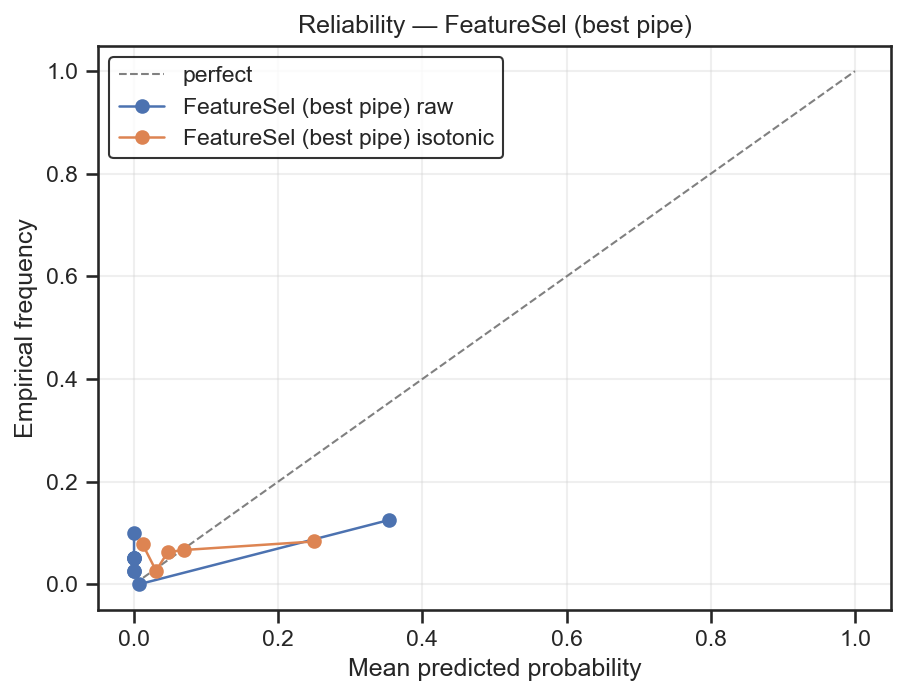

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/01_reliability_Logistic.png


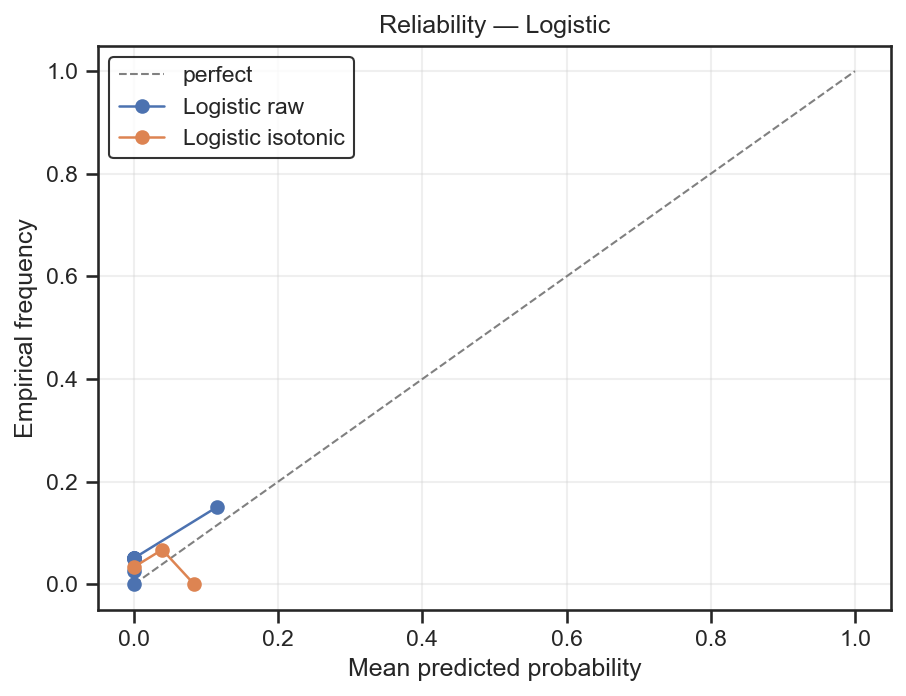

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/01_reliability_MLP.png


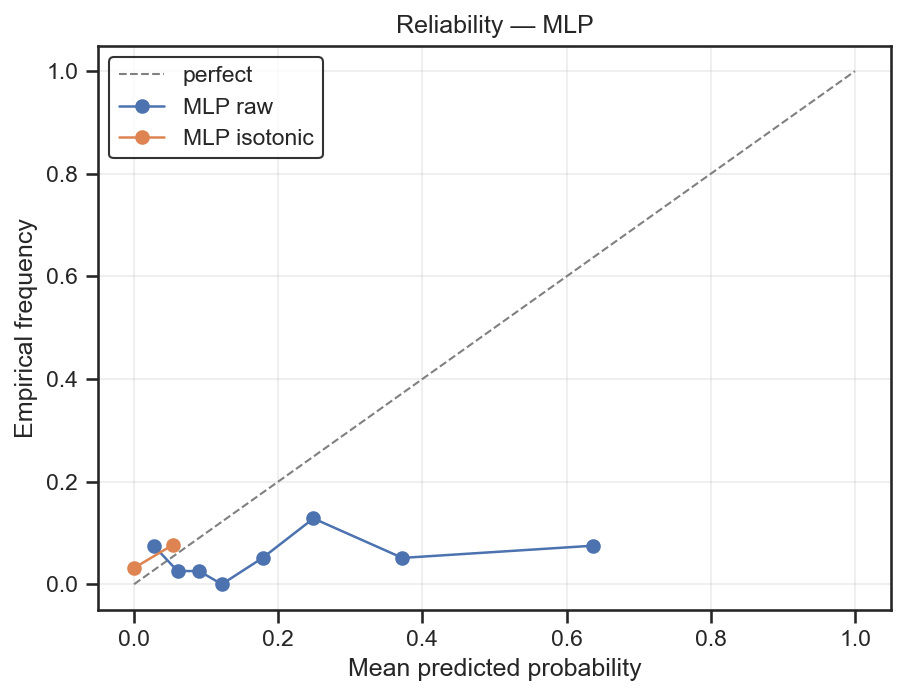

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/01_reliability_RandomForest.png


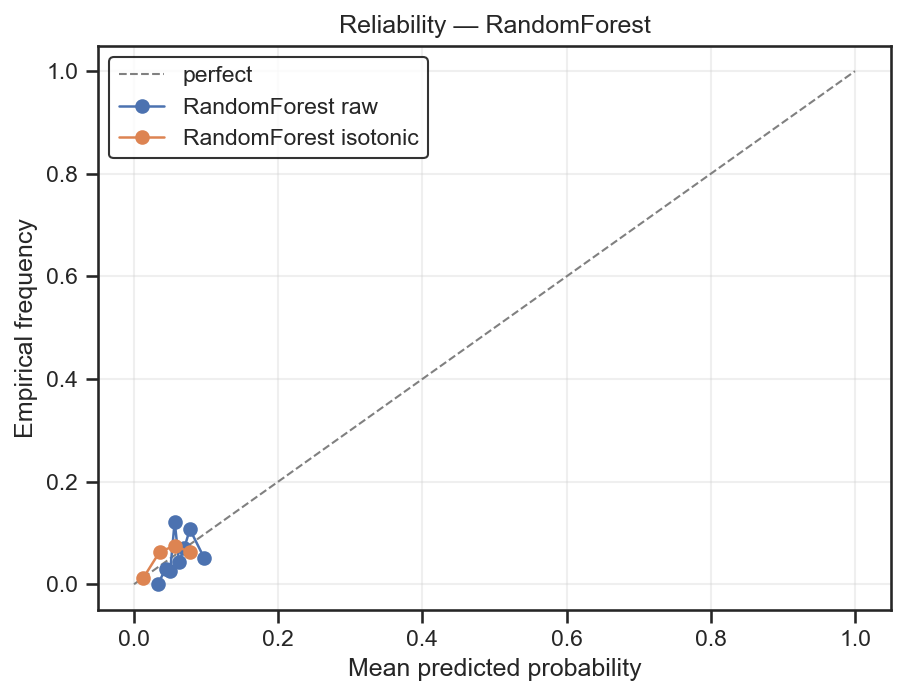

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/01_reliability_Stacking_(meta).png


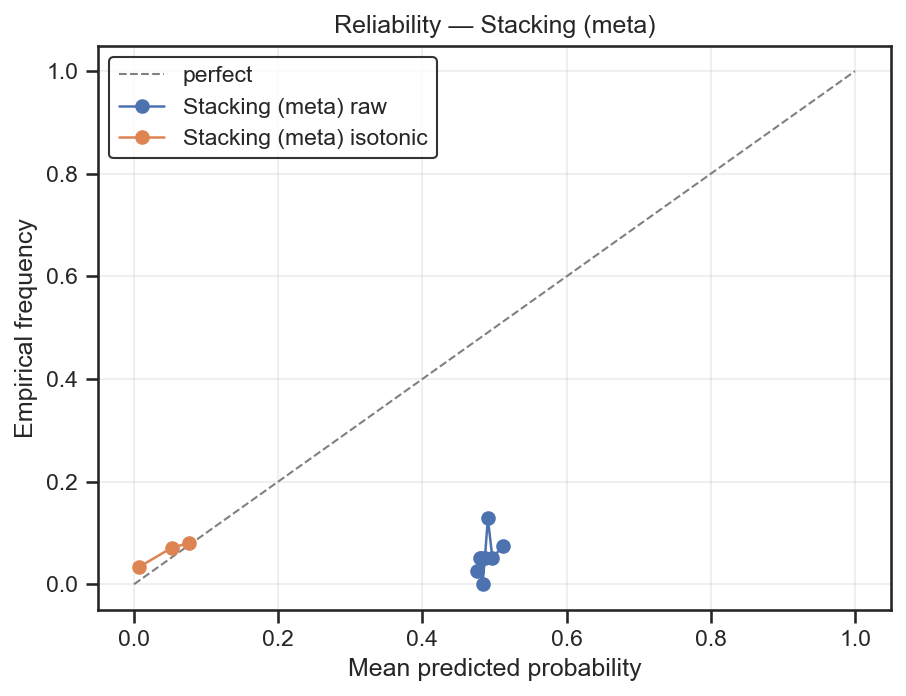

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/01_reliability_XGBoost.png


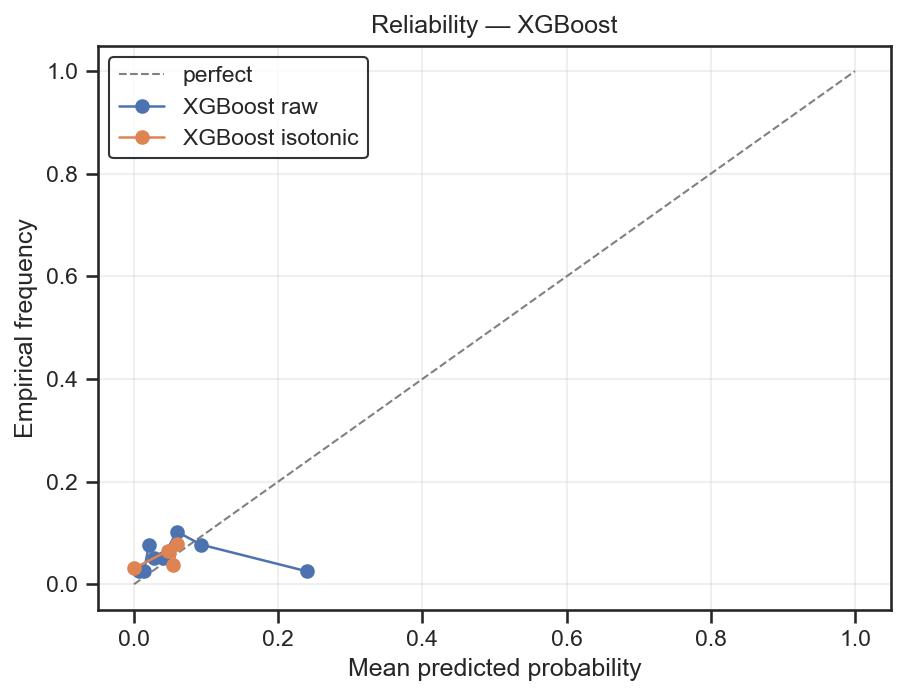

In [7]:
# ---------- Helper: access raw vs calibrated probs ----------
def get_probs(model, split="test", calibrated="raw"):
    """
    split: 'val' or 'test'
    calibrated: 'raw' or 'iso'
    """
    if split not in {"val","test"}:
        raise ValueError("split must be 'val' or 'test'")
    base = val_probs if split=="val" else test_probs

    if calibrated == "iso":
        iso_dict = cal_val_probs if split=="val" else cal_test_probs
        return iso_dict.get(model, base.get(model))
    return base.get(model)

# ---------- Reliability plots (TEST; raw vs isotonic) ----------
def reliability_plot(model, bins=8):
    p_raw = get_probs(model, split="test", calibrated="raw")
    p_iso = get_probs(model, split="test", calibrated="iso")
    if p_raw is None or p_iso is None:
        print(f"[skip] {model} missing probabilities.")
        return
    f_raw, m_raw = calibration_curve(yte, p_raw, n_bins=bins, strategy="quantile")
    f_iso, m_iso = calibration_curve(yte, p_iso, n_bins=bins, strategy="quantile")

    plt.figure(figsize=(6.2, 4.8))
    plt.plot([0,1],[0,1],"--", color="gray", lw=1, label="perfect")
    plt.plot(m_raw, f_raw, "o-", lw=1.2, label=f"{model} raw")
    plt.plot(m_iso, f_iso, "o-", lw=1.2, label=f"{model} isotonic")
    plt.xlabel("Mean predicted probability"); plt.ylabel("Empirical frequency")
    plt.title(f"Reliability — {model}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    savefig(f"01_reliability_{model.replace(' ','_')}.png")
    plt.show()

for m in sorted(test_probs.keys()):
    reliability_plot(m)

### 2. Decision Curve Analysis (TEST; raw vs isotonic)

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/02_dca_raw.png


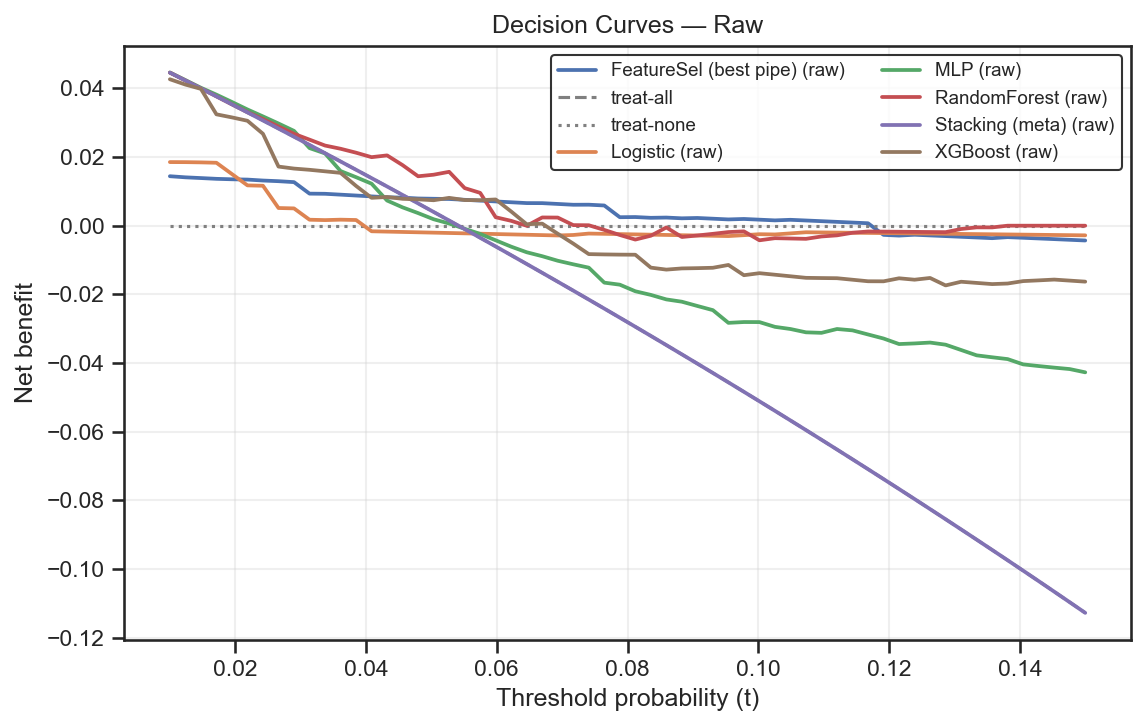

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/02_dca_iso.png


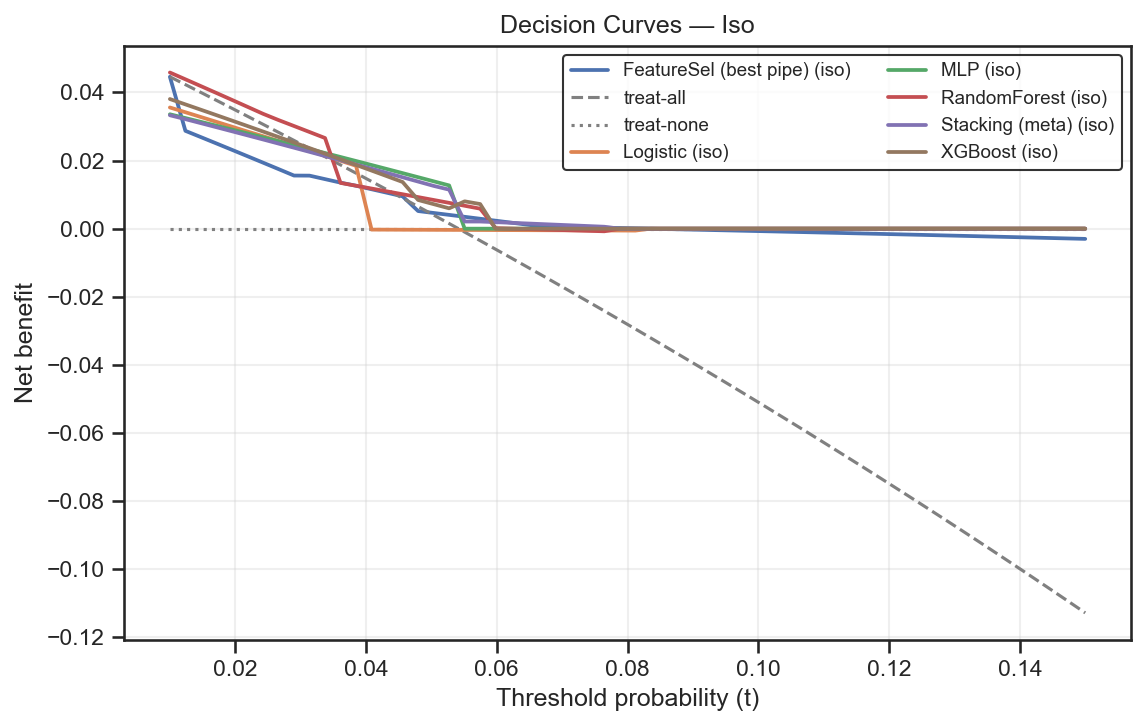

In [8]:
# ---------- Decision Curve Analysis (TEST; raw vs isotonic) ----------
def decision_curve(y, p, thresholds):
    y = np.asarray(y, dtype=int)
    p = np.asarray(p, dtype=float)
    N = len(y); prev = y.mean()
    out = []
    for t in thresholds:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        w = t / (1.0 - t + 1e-12)
        nb_model = (tp / N) - (fp / N) * w
        nb_all   = prev - (1 - prev) * w
        out.append((t, nb_model, nb_all))
    out = np.array(out)
    return out[:,0], out[:,1], out[:,2]

t_grid = np.linspace(0.01, 0.15, 60)

def plot_dca(models=None, calibrated="raw"):
    if models is None:
        models = sorted(test_probs.keys())

    plt.figure(figsize=(7.8, 5.0))
    show_baselines = True
    for m in models:
        p = get_probs(m, split="test", calibrated=calibrated)
        if p is None: 
            continue
        t, nb, nb_all = decision_curve(yte, p, t_grid)
        plt.plot(t, nb, lw=1.8, label=f"{m} ({calibrated})")
        if show_baselines:
            plt.plot(t, nb_all, "--", color="gray", label="treat-all")
            plt.plot(t, np.zeros_like(t), ":", color="gray", label="treat-none")
            show_baselines = False

    plt.xlabel("Threshold probability (t)")
    plt.ylabel("Net benefit")
    plt.title(f"Decision Curves — {calibrated.capitalize()}")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    savefig(f"02_dca_{calibrated}.png")
    plt.show()

plot_dca(calibrated="raw")
plot_dca(calibrated="iso")

In [9]:
# === Dynamic comparison: Raw vs Isotonic (VAL/TEST + DCA summary) ===
def _delta(a_cal, a_raw): 
    return float(a_cal) - float(a_raw)

# 1) Start from df_iso already computed
cols_keep = [
    "Model",
    "Brier_VAL_raw","Brier_VAL_cal",
    "PRAUC_VAL_raw","PRAUC_VAL_cal",
    "ROCAUC_VAL_raw","ROCAUC_VAL_cal",
    "Brier_TEST_raw","Brier_TEST_cal",
    "PRAUC_TEST_raw","PRAUC_TEST_cal",
    "ROCAUC_TEST_raw","ROCAUC_TEST_cal"
]
tbl = df_iso[cols_keep].copy()

# 2) Add VAL/TEST deltas (calibrated - raw)
tbl["ΔBrier_VAL"] = tbl["Brier_VAL_cal"] - tbl["Brier_VAL_raw"]          # negative is better
tbl["ΔPR_AUC_VAL"] = tbl["PRAUC_VAL_cal"] - tbl["PRAUC_VAL_raw"]
tbl["ΔROC_AUC_VAL"] = tbl["ROCAUC_VAL_cal"] - tbl["ROCAUC_VAL_raw"]

tbl["ΔBrier_TEST"] = tbl["Brier_TEST_cal"] - tbl["Brier_TEST_raw"]        # negative is better
tbl["ΔPR_AUC_TEST"] = tbl["PRAUC_TEST_cal"] - tbl["PRAUC_TEST_raw"]
tbl["ΔROC_AUC_TEST"] = tbl["ROCAUC_TEST_cal"] - tbl["ROCAUC_TEST_raw"]

# 3) Decision-curve utility summary: area under net benefit (AUNB) on TEST
def aunb_for(model, calibrated="raw", thresholds=None):
    if thresholds is None:
        thresholds = t_grid
    p = get_probs(model, split="test", calibrated=calibrated)
    if p is None:
        return np.nan
    t, nb, _nb_all = decision_curve(yte, p, thresholds)
    # simple trapezoidal area over threshold range
    return float(np.trapz(nb, t))

tbl["AUNB_raw"] = tbl["Model"].apply(lambda m: aunb_for(m, "raw", t_grid))
tbl["AUNB_iso"] = tbl["Model"].apply(lambda m: aunb_for(m, "iso", t_grid))
tbl["ΔAUNB"]    = tbl["AUNB_iso"] - tbl["AUNB_raw"]

# 4) Nicely formatted view
view_cols = [
    "Model",
    # TEST metrics first (often primary)
    "Brier_TEST_raw","Brier_TEST_cal","ΔBrier_TEST",
    "PRAUC_TEST_raw","PRAUC_TEST_cal","ΔPR_AUC_TEST",
    "ROCAUC_TEST_raw","ROCAUC_TEST_cal","ΔROC_AUC_TEST",
    # VAL (diagnostic)
    "Brier_VAL_raw","Brier_VAL_cal","ΔBrier_VAL",
    "PRAUC_VAL_raw","PRAUC_VAL_cal","ΔPR_AUC_VAL",
    "ROCAUC_VAL_raw","ROCAUC_VAL_cal","ΔROC_AUC_VAL",
    # DCA summary
    "AUNB_raw","AUNB_iso","ΔAUNB"
]
tbl_view = (tbl[view_cols]
            .sort_values(["ΔBrier_TEST","ΔAUNB"], ascending=[True, False])  # best: lower ΔBrier, higher ΔAUNB
            .reset_index(drop=True)
            .round(4))

display(tbl_view)

# Optional: quick legend for interpretation
print("Notes: Δ values are (calibrated − raw). For Brier and ΔBrier, more negative = better; for AUCs and ΔAUNB, more positive = better.")

,Model,Brier_TEST_raw,Brier_TEST_cal,ΔBrier_TEST,PRAUC_TEST_raw,PRAUC_TEST_cal,ΔPR_AUC_TEST,ROCAUC_TEST_raw,ROCAUC_TEST_cal,ΔROC_AUC_TEST,...,ΔBrier_VAL,PRAUC_VAL_raw,PRAUC_VAL_cal,ΔPR_AUC_VAL,ROCAUC_VAL_raw,ROCAUC_VAL_cal,ΔROC_AUC_VAL,AUNB_raw,AUNB_iso,ΔAUNB
0,Stacking (meta),0.2396,0.0513,-0.1883,0.0791,0.0690,-0.0101,0.6039,0.6005,-0.0034,...,-0.2074,0.0487,0.0614,0.0127,0.5906,0.7065,0.1159,-0.0042,0.0010,0.0052
1,MLP,0.1133,0.0515,-0.0618,0.0736,0.0702,-0.0034,0.5847,0.6105,0.0258,...,-0.1519,0.0370,0.0542,0.0172,0.5190,0.6821,0.1631,-0.0015,0.0010,0.0025
2,FeatureSel (best pipe),0.0758,0.0527,-0.0231,0.0832,0.0613,-0.0219,0.5249,0.5182,-0.0067,...,-0.0064,0.0712,0.0753,0.0041,0.5924,0.6707,0.0783,0.0006,0.0007,0.0001
3,Logistic,0.0625,0.0519,-0.0106,0.1196,0.0642,-0.0554,0.6425,0.5760,-0.0665,...,-0.0756,0.0359,0.0452,0.0093,0.4154,0.5980,0.1826,0.0000,0.0008,0.0008
4,XGBoost,0.0607,0.0513,-0.0094,0.0606,0.0692,0.0086,0.5522,0.5912,0.0390,...,-0.0049,0.0505,0.0576,0.0071,0.6418,0.7003,0.0585,-0.0002,0.0010,0.0012
5,RandomForest,0.0510,0.0510,0.0000,0.0715,0.0696,-0.0019,0.6172,0.6173,0.0001,...,-0.0010,0.0531,0.0554,0.0023,0.6230,0.6737,0.0507,0.0011,0.0011,0.0000


Notes: Δ values are (calibrated − raw). For Brier and ΔBrier, more negative = better; for AUCs and ΔAUNB, more positive = better.


### 3. Compact forest-style plot for calibration deltas.

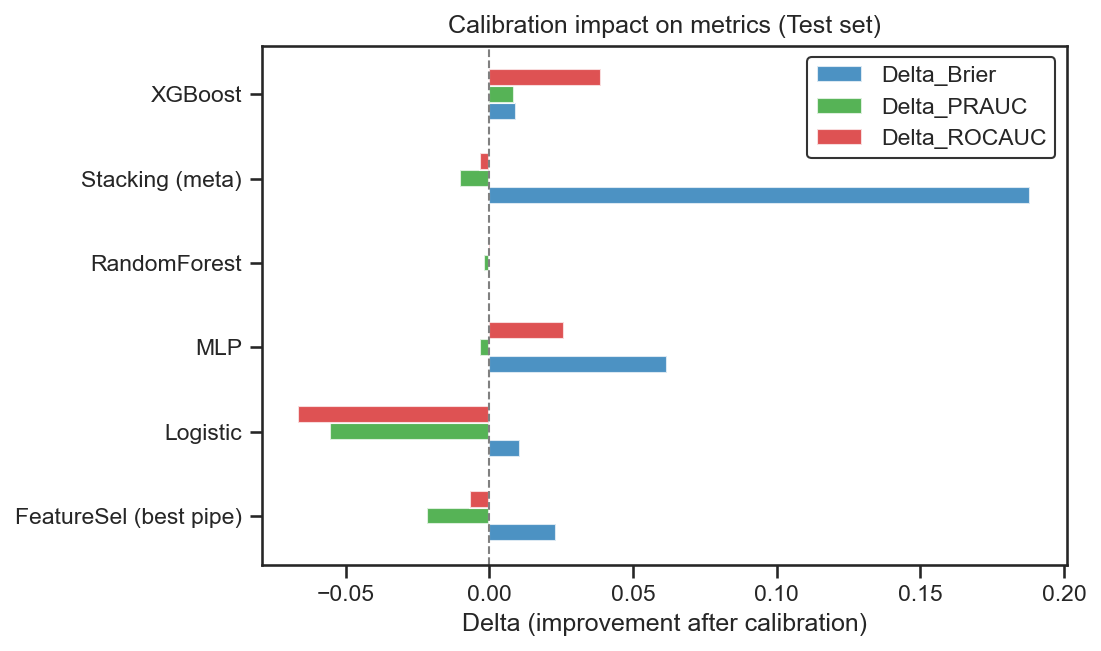

,Model,Delta_Brier,Delta_PRAUC,Delta_ROCAUC
0,FeatureSel (best pipe),0.0231,-0.0219,-0.0067
1,Logistic,0.0106,-0.0554,-0.0665
2,MLP,0.0618,-0.0034,0.0258
3,RandomForest,0.0000,-0.0019,0.0001
4,Stacking (meta),0.1883,-0.0101,-0.0034
5,XGBoost,0.0094,0.0086,0.0390


In [10]:
# Compute deltas (calibrated - raw), flipping Brier so that positive = improvement
delta_rows = []
for _, row in df_iso.iterrows():
    model = row["Model"]
    # flip Brier: improvement = raw - cal
    d_brier = row["Brier_TEST_raw"] - row["Brier_TEST_cal"]
    d_prauc = row["PRAUC_TEST_cal"] - row["PRAUC_TEST_raw"]
    d_roc   = row["ROCAUC_TEST_cal"] - row["ROCAUC_TEST_raw"]
    delta_rows.append({
        "Model": model,
        "Delta_Brier": d_brier,
        "Delta_PRAUC": d_prauc,
        "Delta_ROCAUC": d_roc
    })

df_delta = pd.DataFrame(delta_rows)

# --- Plot forest-style (all positive = improvement) ---
fig, ax = plt.subplots(figsize=(7.5, 4.5))
metrics = ["Delta_Brier", "Delta_PRAUC", "Delta_ROCAUC"]
colors = {"Delta_Brier": "tab:blue", "Delta_PRAUC": "tab:green", "Delta_ROCAUC": "tab:red"}

y = np.arange(len(df_delta))
bar_height = 0.2

for i, metric in enumerate(metrics):
    ax.barh(
        y + (i-1)*bar_height,
        df_delta[metric],
        height=bar_height,
        color=colors[metric],
        alpha=0.8,
        label=metric
    )

ax.axvline(0, color="gray", lw=1, ls="--")
ax.set_yticks(y)
ax.set_yticklabels(df_delta["Model"])
ax.set_xlabel("Delta (improvement after calibration)")
ax.set_title("Calibration impact on metrics (Test set)")
ax.legend()
plt.tight_layout()
plt.show()

display(df_delta.round(4))

### 4. Re-tune thresholds on calibrated (isotonic) probabilities and compare against raw.

In [11]:
# --- 1) Helpers: thresholds on validation, eval on test ---
def _align_pr(y, p):
    P, R, T = precision_recall_curve(y, p)
    return P[:-1], R[:-1], T  # align thresholds (T has length n-1)

def thr_f1_from_val(y, p, beta=1.0):
    P, R, T = _align_pr(y, p)
    F = (1+beta**2)*(P*R) / (beta**2*P + R + 1e-12)
    i = int(np.nanargmax(F)) if len(F) else 0
    return float(T[i]) if len(T) else 0.5

def thr_recall_from_val(y, p, recall_floor=0.10):
    P, R, T = _align_pr(y, p)
    ok = np.where(R >= recall_floor)[0]
    if ok.size:
        j = ok[np.argmax(P[ok])]  # highest precision subject to recall >= floor
        return float(T[j])
    return float(T[-1]) if len(T) else 0.0

def eval_at(y, p, t):
    pred = (p >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    precision = tp/(tp+fp) if (tp+fp)>0 else 0.0
    recall    = tp/(tp+fn) if (tp+fn)>0 else 0.0
    balacc    = balanced_accuracy_score(y, pred)
    return precision, recall, balacc

In [12]:
# --- 2) Re-tune thresholds on VAL (raw vs iso), report on TEST ---
rows = []
models = sorted(test_probs.keys())
for m in models:
    for cal in ("raw", "iso"):
        pv = get_probs(m, split="val",  calibrated=cal)
        pt = get_probs(m, split="test", calibrated=cal)
        if pv is None or pt is None:
            continue

        t_f1  = thr_f1_from_val(yva, pv)
        t_r10 = thr_recall_from_val(yva, pv, recall_floor=0.10)

        p_f1, r_f1, b_f1   = eval_at(yte, pt, t_f1)
        p_r10, r_r10, b_r10 = eval_at(yte, pt, t_r10)

        rows.append({
            "Model": m, "Calib": cal,
            "thr_F1": t_f1, "Precision@F1": p_f1, "Recall@F1": r_f1, "BalancedAcc@F1": b_f1,
            "thr_Rec>=10%": t_r10, "Precision@Rec>=10%": p_r10, "Recall@Rec>=10%": r_r10, "BalancedAcc@Rec>=10%": b_r10,
            "PR_AUC_test": average_precision_score(yte, pt),
        })

df_thr = (pd.DataFrame(rows)
          .sort_values(["Model","Calib"])
          .reset_index(drop=True))

display(df_thr.round({
    "thr_F1":4, "Precision@F1":3, "Recall@F1":3, "BalancedAcc@F1":3,
    "thr_Rec>=10%":4, "Precision@Rec>=10%":3, "Recall@Rec>=10%":3, "BalancedAcc@Rec>=10%":3,
    "PR_AUC_test":3
}))

,Model,Calib,thr_F1,Precision@F1,Recall@F1,BalancedAcc@F1,thr_Rec>=10%,Precision@Rec>=10%,Recall@Rec>=10%,BalancedAcc@Rec>=10%,PR_AUC_test
0,FeatureSel (best pipe),iso,0.0690,0.069,0.294,0.534,0.0690,0.069,0.294,0.534,0.061
1,FeatureSel (best pipe),raw,0.0018,0.069,0.294,0.534,0.0018,0.069,0.294,0.534,0.083
2,Logistic,iso,0.0833,0.000,0.000,0.497,0.0394,0.067,0.765,0.579,0.064
3,Logistic,raw,0.9536,0.000,0.000,0.497,0.0000,0.067,0.765,0.579,0.120
4,MLP,iso,0.0542,0.077,0.706,0.611,0.0542,0.077,0.706,0.611,0.070
5,MLP,raw,0.1509,0.077,0.706,0.611,0.1509,0.077,0.706,0.611,0.074
6,RandomForest,iso,0.0575,0.073,0.471,0.565,0.0575,0.073,0.471,0.565,0.070
7,RandomForest,raw,0.0675,0.073,0.471,0.565,0.0675,0.073,0.471,0.565,0.072
8,Stacking (meta),iso,0.0769,0.083,0.118,0.522,0.0769,0.083,0.118,0.522,0.069
9,Stacking (meta),raw,0.5087,0.083,0.118,0.522,0.5087,0.083,0.118,0.522,0.079


In [13]:
# --- 3) Compact diffs (iso - raw) at both operating points ---
def _pivot_diff(df, metric_col):
    wide = (df.pivot(index="Model", columns="Calib", values=metric_col)
              .reindex(columns=["raw","iso"]))
    if {"raw","iso"}.issubset(wide.columns):
        return (wide["iso"] - wide["raw"]).rename(metric_col + " Δ(iso-raw)")
    return pd.Series(dtype=float, name=metric_col + " Δ(iso-raw)")

diff_cols = [
    "Precision@F1","Recall@F1","BalancedAcc@F1",
    "Precision@Rec>=10%","Recall@Rec>=10%","BalancedAcc@Rec>=10%",
    "PR_AUC_test"
]
diff_table = pd.concat([_pivot_diff(df_thr, c) for c in diff_cols], axis=1)
display(diff_table.round(3))

,Precision@F1 Δ(iso-raw),Recall@F1 Δ(iso-raw),BalancedAcc@F1 Δ(iso-raw),Precision@Rec>=10% Δ(iso-raw),Recall@Rec>=10% Δ(iso-raw),BalancedAcc@Rec>=10% Δ(iso-raw),PR_AUC_test Δ(iso-raw)
Model,,,,,,,
FeatureSel (best pipe),0.0,0.0,0.0,0.0,0.0,0.0,-0.022
Logistic,0.0,0.0,0.0,0.0,0.0,0.0,-0.055
MLP,0.0,0.0,0.0,0.0,0.0,0.0,-0.003
RandomForest,0.0,0.0,0.0,0.0,0.0,0.0,-0.002
Stacking (meta),0.0,0.0,0.0,0.0,0.0,0.0,-0.010
XGBoost,0.0,0.0,0.0,0.0,0.0,0.0,0.009


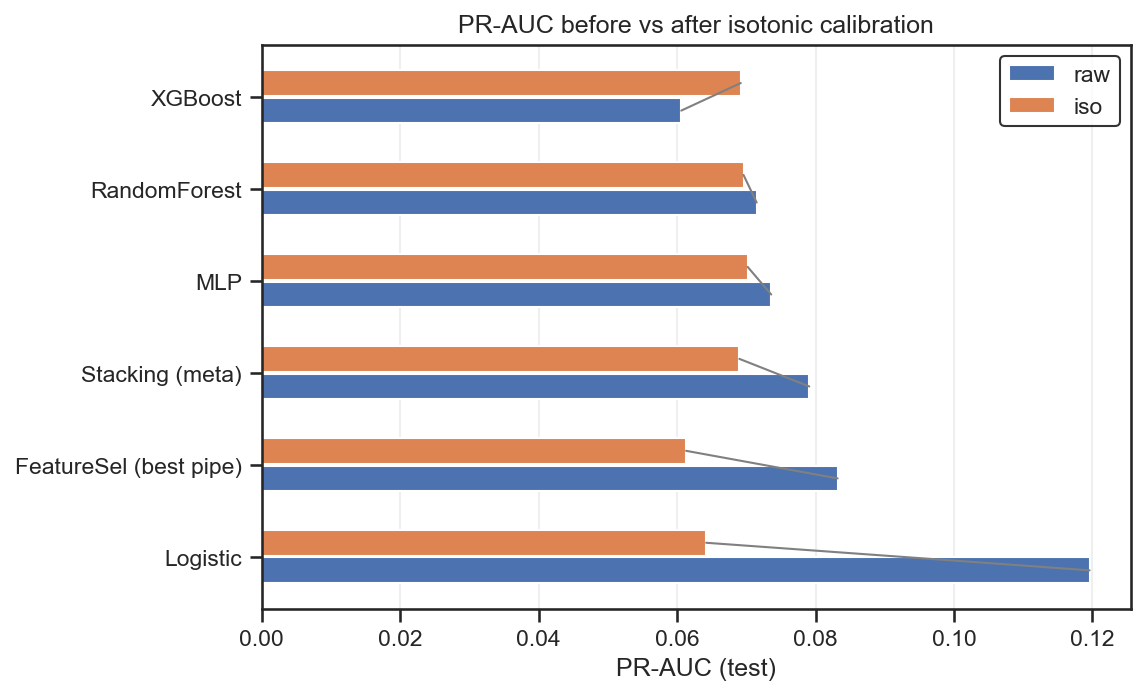

In [14]:
# === PR-AUC before vs after (paired bars with connector lines) ===
df_pairs = (df_iso[["Model","PRAUC_TEST_raw","PRAUC_TEST_cal"]]
            .rename(columns={"PRAUC_TEST_raw":"raw","PRAUC_TEST_cal":"iso"}))
df_pairs["delta"] = df_pairs["iso"] - df_pairs["raw"]
df_pairs = df_pairs.sort_values("delta")  # sort by change

fig, ax = plt.subplots(figsize=(7.8, 4.8))
y = np.arange(len(df_pairs))
ax.barh(y-0.15, df_pairs["raw"], height=0.28, label="raw")
ax.barh(y+0.15, df_pairs["iso"], height=0.28, label="iso")

# connector lines
for i, (_, r) in enumerate(df_pairs.iterrows()):
    ax.plot([r["raw"], r["iso"]], [y[i]-0.15, y[i]+0.15], color="gray", lw=1)

ax.set_yticks(y)
ax.set_yticklabels(df_pairs["Model"])
ax.set_xlabel("PR-AUC (test)")
ax.set_title("PR-AUC before vs after isotonic calibration")
ax.legend()
ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout(); plt.show()

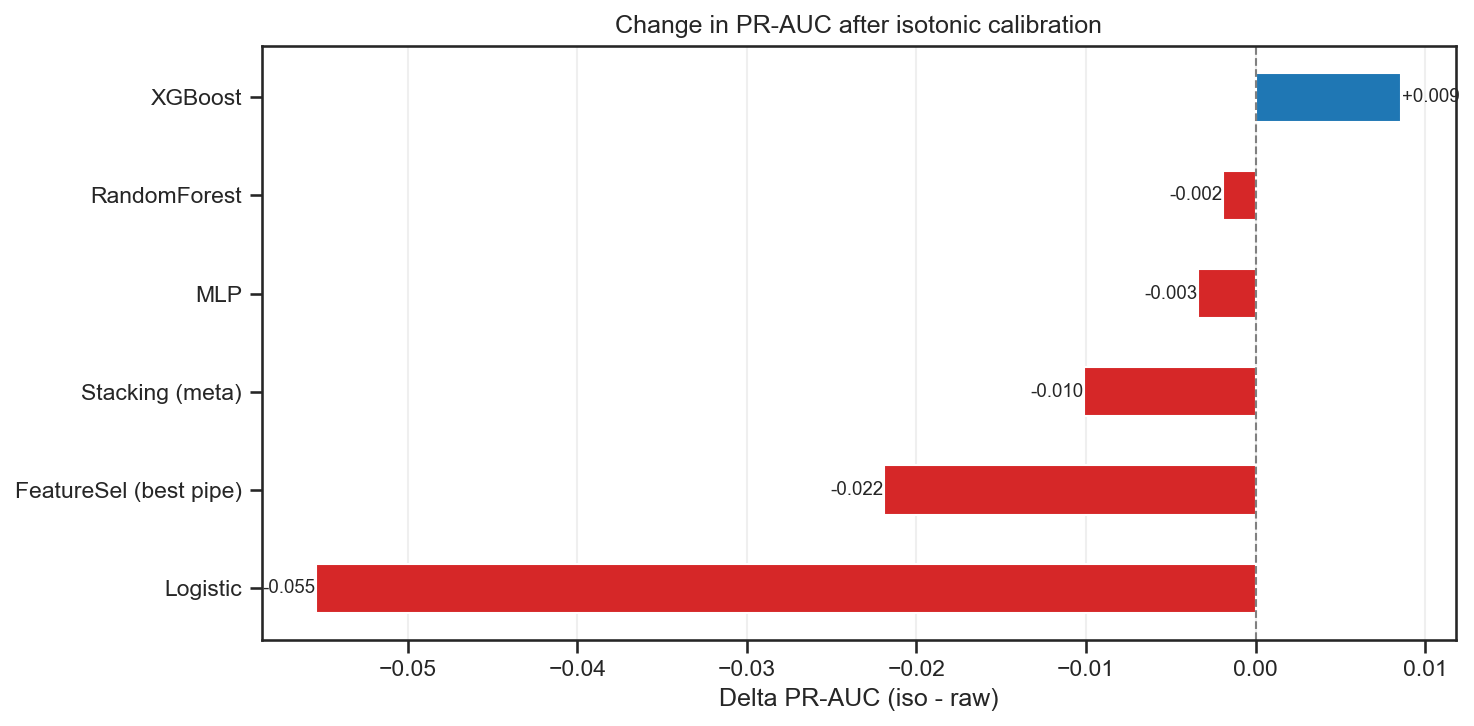

In [15]:
# === Delta-only forest (iso - raw), annotated ===
df_delta_prau = df_pairs[["Model","delta"]].copy()

fig, ax = plt.subplots(figsize=(10, 5))
y = np.arange(len(df_delta_prau))
ax.barh(y, df_delta_prau["delta"], height=0.5, color=np.where(df_delta_prau["delta"]>=0, "tab:blue", "tab:red"))
ax.axvline(0, color="gray", lw=1, ls="--")
for i, v in enumerate(df_delta_prau["delta"]):
    ax.text(v + (0.00003 if v>=0 else -0.00003), i, f"{v:+.3f}",
            va="center", ha="left" if v>=0 else "right", fontsize=9)
ax.set_yticks(y)
ax.set_yticklabels(df_delta_prau["Model"])
ax.set_xlabel("Delta PR-AUC (iso - raw)")
ax.set_title("Change in PR-AUC after isotonic calibration")
ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout(); plt.show()

### 5. Cost-sensitive sweep: RAW vs ISOTONIC

Per-ratio winners — RAW


,Ratio,Model,Cost,thr,Precision,Recall,BalancedAcc
0,1,FeatureSel (best pipe),17,1.000000,0.000000,0.000000,0.500000
1,2,FeatureSel (best pipe),34,1.000000,0.000000,0.000000,0.500000
2,3,Logistic,47,1.000000,0.300000,0.352941,0.652902
3,4,Logistic,58,1.000000,0.300000,0.352941,0.652902
4,5,Logistic,69,1.000000,0.300000,0.352941,0.652902
5,6,Logistic,80,1.000000,0.300000,0.352941,0.652902
6,7,Logistic,91,1.000000,0.300000,0.352941,0.652902
7,8,Logistic,102,1.000000,0.300000,0.352941,0.652902
8,9,Logistic,113,1.000000,0.300000,0.352941,0.652902
9,10,Logistic,124,1.000000,0.300000,0.352941,0.652902


Per-ratio winners — ISOTONIC


,Ratio,Model,Cost,thr,Precision,Recall,BalancedAcc
0,1,FeatureSel (best pipe),17,1.000000,0.000000,0.000000,0.500000
1,2,FeatureSel (best pipe),34,1.000000,0.000000,0.000000,0.500000
2,3,FeatureSel (best pipe),51,0.250000,0.000000,0.000000,0.500000
3,4,FeatureSel (best pipe),68,0.250000,0.000000,0.000000,0.500000
4,5,FeatureSel (best pipe),85,0.250000,0.000000,0.000000,0.500000
5,6,FeatureSel (best pipe),102,0.250000,0.000000,0.000000,0.500000
6,7,FeatureSel (best pipe),119,0.250000,0.000000,0.000000,0.500000
7,8,FeatureSel (best pipe),136,0.250000,0.000000,0.000000,0.500000
8,9,FeatureSel (best pipe),153,0.250000,0.000000,0.000000,0.500000
9,10,FeatureSel (best pipe),170,0.250000,0.000000,0.000000,0.500000



Stable crossovers vs baseline (RAW): Logistic


,Model,Crossover_at_ratio
0,FeatureSel (best pipe),no clean crossover
1,MLP,19:1
2,RandomForest,19:1
3,Stacking (meta),19:1
4,XGBoost,21:1



Stable crossovers vs baseline (ISOTONIC): Logistic


,Model,Crossover_at_ratio
0,FeatureSel (best pipe),12:1
1,MLP,13:1
2,RandomForest,13:1
3,Stacking (meta),12:1
4,XGBoost,12:1


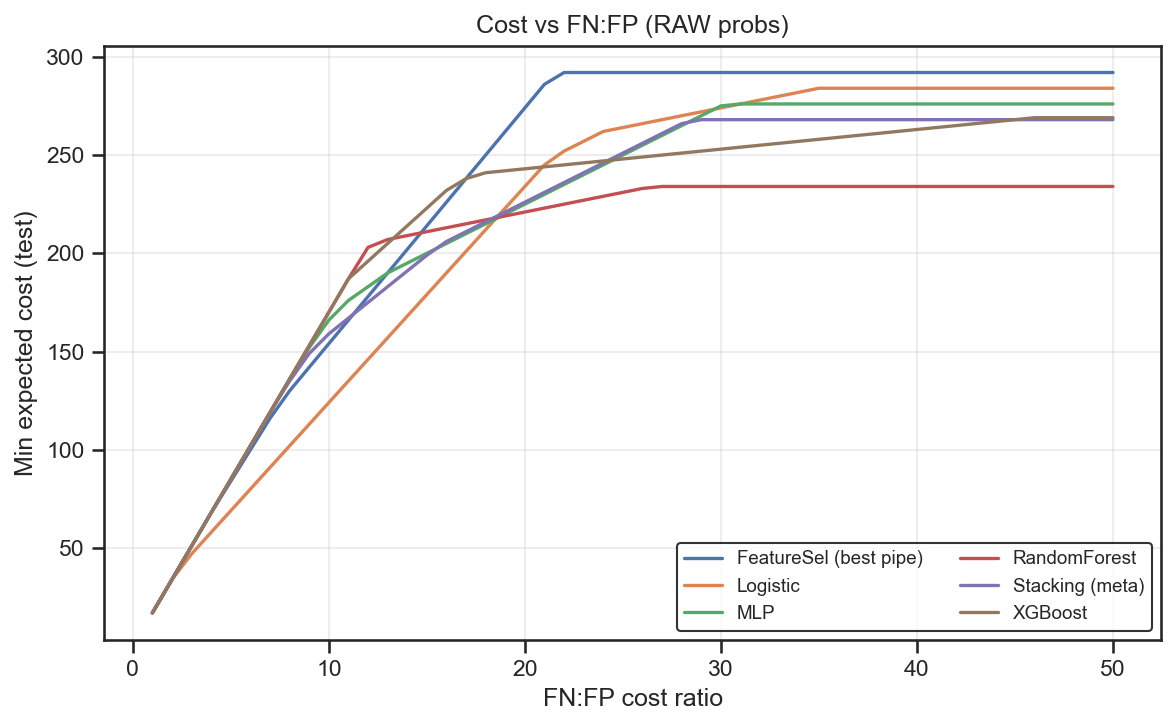

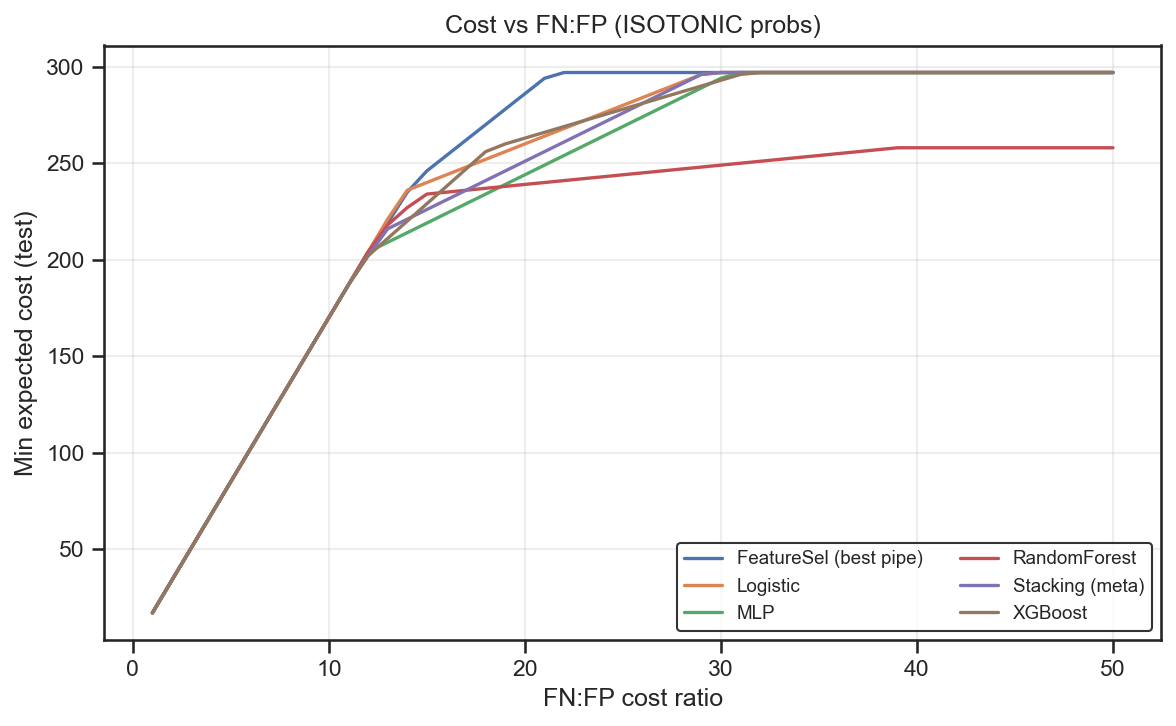

In [16]:
# Uses your existing get_probs(model, split, calibrated) helper.

BASELINE  = "Logistic"   # change if needed
MAX_RATIO = 50
STEP      = 1
K_STABLE  = 3
ratios    = list(range(1, MAX_RATIO+1, STEP))
models    = sorted(test_probs.keys())

def best_cost_for_ratio(y_true, p, ratio):
    # search thresholds from PR curve + extremes
    prec, rec, thr = precision_recall_curve(y_true, p)
    thr_grid = np.unique(np.r_[thr, 0.0, 1.0])
    best = None
    for t in thr_grid:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, pred).ravel()
        cost = fp*1 + fn*ratio
        if (best is None) or (cost < best["Cost"]):
            best = {"thr": float(t), "Cost": int(cost),
                    "Precision": tp/(tp+fp) if (tp+fp)>0 else 0.0,
                    "Recall":    tp/(tp+fn) if (tp+fn)>0 else 0.0,
                    "BalancedAcc": balanced_accuracy_score(y_true, pred),
                    "PR_AUC": average_precision_score(y_true, p),
                    "ROC_AUC": roc_auc_score(y_true, p),
                    "TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn)}
    return best

def sweep_cost(curve_source="raw"):
    rows = []
    for m in models:
        p_val  = get_probs(m, split="val",  calibrated=curve_source)
        p_test = get_probs(m, split="test", calibrated=curve_source)
        if p_val is None or p_test is None: 
            continue
        for r in ratios:
            # tune threshold on VAL under cost ratio r
            best_val = best_cost_for_ratio(yva, p_val, r)
            # evaluate on TEST with that threshold
            t = best_val["thr"]
            res = best_cost_for_ratio(yte, p_test, r)
            res.update({"Model": m, "Ratio": r, "thr": t})
            rows.append(res)
    return pd.DataFrame(rows)

df_cost_raw = sweep_cost("raw")
df_cost_iso = sweep_cost("iso")

def per_ratio_winners(df):
    return (df.loc[df.groupby("Ratio")["Cost"].idxmin(), 
                   ["Ratio","Model","Cost","thr","Precision","Recall","BalancedAcc"]]
              .reset_index(drop=True))

print("Per-ratio winners — RAW")
display(per_ratio_winners(df_cost_raw))
print("Per-ratio winners — ISOTONIC")
display(per_ratio_winners(df_cost_iso))

# ---- stable crossover vs baseline (same logic as earlier) ----
def crossovers_vs_baseline(df_cost, baseline, ratios, k=K_STABLE, max_ratio=MAX_RATIO):
    if baseline not in df_cost["Model"].unique():
        return pd.DataFrame(columns=["Model","Crossover_at_ratio"])
    base = (df_cost[df_cost.Model==baseline].set_index("Ratio")["Cost"].reindex(ratios))
    out = []
    for name in df_cost["Model"].unique():
        if name == baseline: 
            continue
        other = (df_cost[df_cost.Model==name].set_index("Ratio")["Cost"].reindex(ratios))
        diff = (other - base).to_numpy()  # negative => other cheaper

        # 1) stable: first window of k consecutive cheaper points
        stable_idx = None
        if len(diff) >= k:
            run = np.convolve((diff < 0).astype(int), np.ones(k, dtype=int), mode="valid")
            hits = np.where(run == k)[0]
            if hits.size: stable_idx = hits[0]
        if stable_idx is not None:
            out.append({"Model": name, "Crossover_at_ratio": f"{ratios[stable_idx]}:1"}); continue

        # 2) any sign flip
        sign = np.sign(diff)
        flip = np.where(sign[:-1]*sign[1:] < 0)[0]
        if flip.size:
            out.append({"Model": name, "Crossover_at_ratio": f"{ratios[flip[0]+1]}:1"}); continue

        # 3) dominance
        if np.all(diff < 0):
            out.append({"Model": name, "Crossover_at_ratio": f"always cheaper (1–{max_ratio}:1)"})
        elif np.all(diff > 0):
            out.append({"Model": name, "Crossover_at_ratio": f"always costlier (1–{max_ratio}:1)"})
        else:
            out.append({"Model": name, "Crossover_at_ratio": "no clean crossover"})
    return pd.DataFrame(out).sort_values("Model")

print("\nStable crossovers vs baseline (RAW):", BASELINE)
display(crossovers_vs_baseline(df_cost_raw, BASELINE, ratios))
print("\nStable crossovers vs baseline (ISOTONIC):", BASELINE)
display(crossovers_vs_baseline(df_cost_iso, BASELINE, ratios))

# ---- plot cost curves (optional, compact) ----
def plot_cost_curves(df, title):
    plt.figure(figsize=(8,5))
    for m in models:
        sub = df[df["Model"]==m]
        if not sub.empty:
            plt.plot(sub["Ratio"], sub["Cost"], label=m, lw=1.6)
    plt.xlabel("FN:FP cost ratio")
    plt.ylabel("Min expected cost (test)")
    plt.title(title)
    plt.grid(True, alpha=0.35); plt.legend(ncol=2, fontsize=9)
    plt.tight_layout(); plt.show()

plot_cost_curves(df_cost_raw, "Cost vs FN:FP (RAW probs)")
plot_cost_curves(df_cost_iso, "Cost vs FN:FP (ISOTONIC probs)")

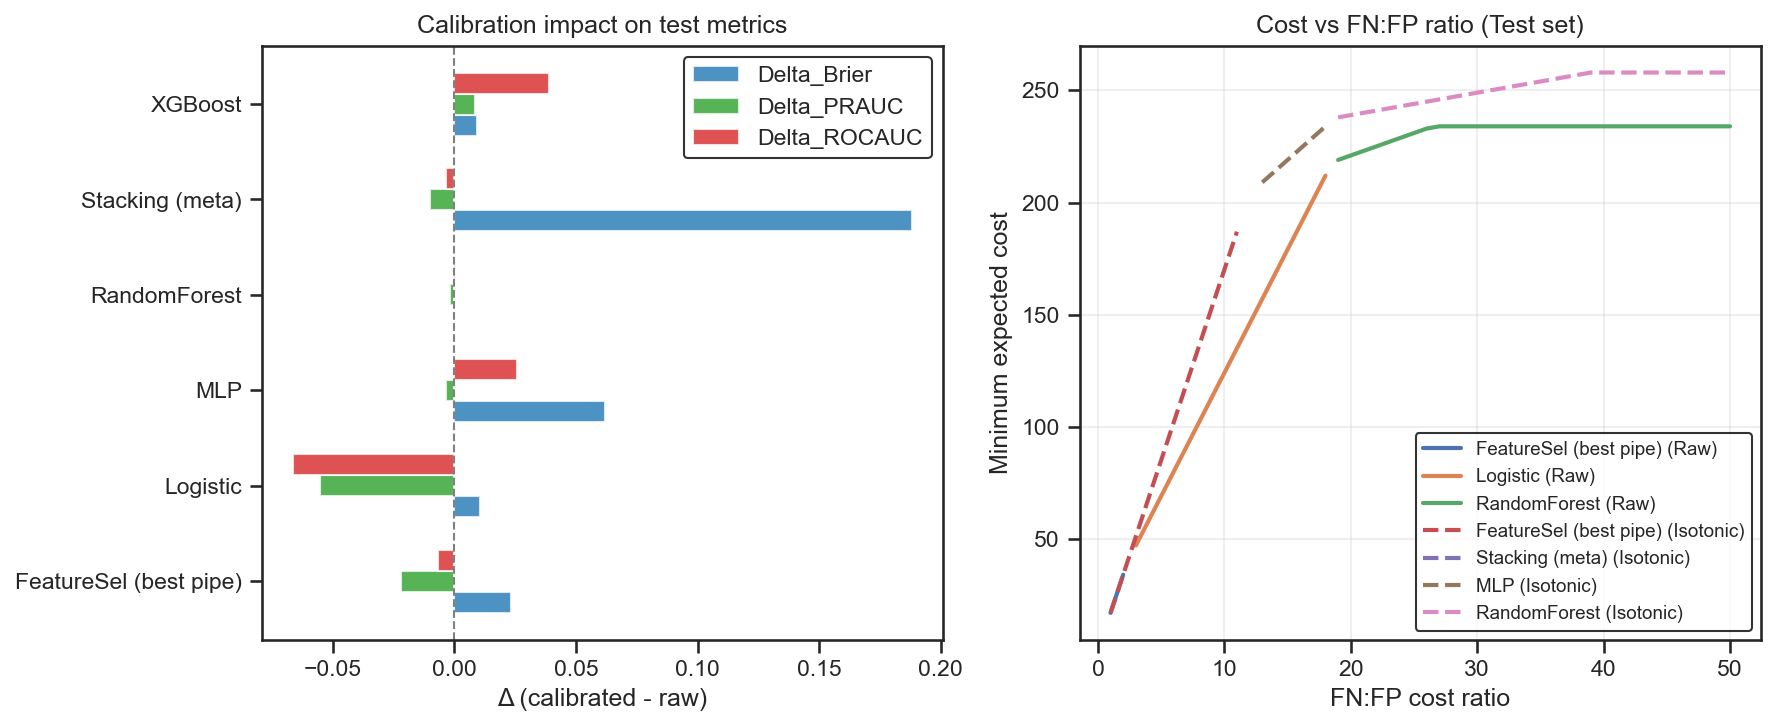

In [17]:
# ---- Visual Summary: Calibration + Cost-Sensitive Sweeps ----

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# (1) Calibration impact (Δ metrics)
metrics = ["Delta_Brier", "Delta_PRAUC", "Delta_ROCAUC"]
colors  = {"Delta_Brier":"tab:blue", "Delta_PRAUC":"tab:green", "Delta_ROCAUC":"tab:red"}
y = np.arange(len(df_delta))
bar_height = 0.22

for i, metric in enumerate(metrics):
    axes[0].barh(y + (i-1)*bar_height, df_delta[metric], 
                 height=bar_height, color=colors[metric], alpha=0.8, label=metric)

axes[0].axvline(0, color="gray", lw=1, ls="--")
axes[0].set_yticks(y)
axes[0].set_yticklabels(df_delta["Model"])
axes[0].set_xlabel("Δ (calibrated - raw)")
axes[0].set_title("Calibration impact on test metrics")
axes[0].legend()

# (2) Cost-sensitive sweep (winner per ratio, raw vs isotonic)
# Winners (RAW)
winners_raw = (
    df_cost_raw.loc[df_cost_raw.groupby("Ratio")["Cost"].idxmin()]
    [["Ratio","Model","Cost","thr","Precision","Recall","BalancedAcc"]]
    .reset_index(drop=True)
)

# Winners (ISOTONIC)
winners_iso = (
    df_cost_iso.loc[df_cost_iso.groupby("Ratio")["Cost"].idxmin()]
    [["Ratio","Model","Cost","thr","Precision","Recall","BalancedAcc"]]
    .reset_index(drop=True)
)
for label, df_winners, style in [
    ("Raw", winners_raw, "-"),
    ("Isotonic", winners_iso, "--")
]:
    for model in df_winners["Model"].unique():
        sub = df_winners[df_winners["Model"]==model]
        axes[1].plot(sub["Ratio"], sub["Cost"], style, lw=2,
                     label=f"{model} ({label})")

axes[1].set_xlabel("FN:FP cost ratio")
axes[1].set_ylabel("Minimum expected cost")
axes[1].set_title("Cost vs FN:FP ratio (Test set)")
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.savefig(RESULT_DIR / "calibration_cost_panel.png", dpi=300, bbox_inches="tight")
plt.show()

### Further experiments:

#### Experiment A: Crossover-shift analysis (RAW vs ISOTONIC) 

,Model,Raw_crossover,Iso_crossover,Shift_in_ratio
0,FeatureSel (best pipe),no clean crossover,12:1,NaN
1,MLP,19:1,13:1,-6.0
2,RandomForest,19:1,13:1,-6.0
3,Stacking (meta),19:1,12:1,-7.0
4,XGBoost,21:1,12:1,-9.0



Winner share by ratio — RAW


,Model,Wins,Share
0,RandomForest,32,0.64
1,Logistic,16,0.32
2,FeatureSel (best pipe),2,0.04



Winner share by ratio — ISOTONIC


,Model,Wins,Share
0,RandomForest,32,0.64
1,FeatureSel (best pipe),11,0.22
2,MLP,6,0.12
3,Stacking (meta),1,0.02


Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/03_crossover_shifts.png


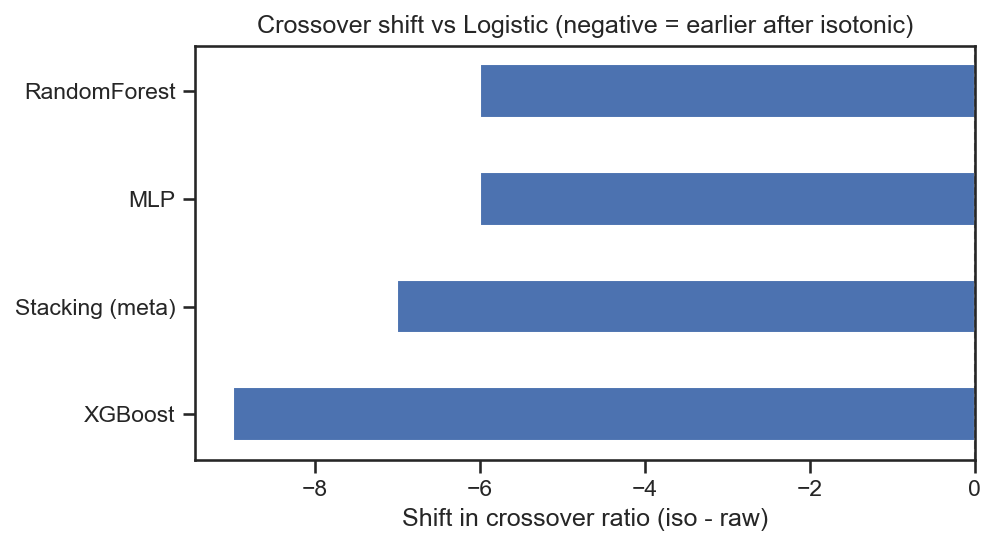

In [18]:
def _to_int_or_nan(txt):
    if isinstance(txt, (int, float)): 
        return int(txt)
    if isinstance(txt, str) and ":" in txt and txt.split(":")[0].isdigit():
        return int(txt.split(":")[0])
    return np.nan

# 1) Crossover tables vs Logistic baseline
xover_raw = crossovers_vs_baseline(df_cost_raw, BASELINE, ratios)
xover_iso = crossovers_vs_baseline(df_cost_iso, BASELINE, ratios)

tab = (xover_raw.rename(columns={"Crossover_at_ratio":"Raw_crossover"})
       .merge(xover_iso.rename(columns={"Crossover_at_ratio":"Iso_crossover"}),
              on="Model", how="outer"))
tab["Raw_ratio"] = tab["Raw_crossover"].apply(_to_int_or_nan)
tab["Iso_ratio"] = tab["Iso_crossover"].apply(_to_int_or_nan)
tab["Shift_in_ratio"] = tab["Iso_ratio"] - tab["Raw_ratio"]

display(tab[["Model","Raw_crossover","Iso_crossover","Shift_in_ratio"]]
        .sort_values("Model"))

# 2) Winner-share summaries
def share_wins(df_winners):
    counts = df_winners["Model"].value_counts().rename_axis("Model").reset_index(name="Wins")
    counts["Share"] = counts["Wins"] / len(df_winners)
    return counts.sort_values("Share", ascending=False)

print("\nWinner share by ratio — RAW")
display(share_wins(winners_raw))
print("\nWinner share by ratio — ISOTONIC")
display(share_wins(winners_iso))

# 3) Visualize crossover shifts
_shift = tab[~tab["Shift_in_ratio"].isna()].copy()
_shift = _shift.sort_values("Shift_in_ratio")

plt.figure(figsize=(6.8, 3.8))
y = np.arange(len(_shift))
plt.barh(y, _shift["Shift_in_ratio"], height=0.5)
plt.axvline(0, color="gray", lw=1, ls="--")
plt.yticks(y, _shift["Model"])
plt.xlabel("Shift in crossover ratio (iso - raw)")
plt.title("Crossover shift vs Logistic (negative = earlier after isotonic)")
plt.tight_layout()
savefig("03_crossover_shifts.png")
plt.show()

In [19]:
# =========================
# Experiment B — Robustness under resampling (RAW vs ISOTONIC)
# =========================
# Goal:
# - Fix thresholds on VALIDATION for each (model, ratio) and for each calibration mode (raw/iso)
# - Bootstrap TEST indices, evaluate cost using FIXED thresholds (no leakage)
# - Summaries: winner share by ratio, crossover distributions vs Logistic, median cost curves + 95% CI

# ---------- config ----------
BASELINE  = "Logistic"
RATIOS    = list(range(1, 51))       # 1..50
K_STABLE  = 3                        # consecutive cheaper points required for crossover
B_LIST    = [200, 500, 1000]         # bootstraps to run; you can subset
RNG       = np.random.default_rng(42)

# ---------- helpers ----------
def best_val_threshold(y_val, p_val, ratio):
    """Pick the threshold that minimizes cost on VALIDATION for a given ratio (FN cost=ratio, FP cost=1)."""
    P, R, T = precision_recall_curve(y_val, p_val)
    thr_grid = np.unique(np.r_[T, 0.0, 1.0])
    best_t, best_cost = None, None
    for t in thr_grid:
        pred = (p_val >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_val, pred).ravel()
        cost = fp*1 + fn*ratio
        if (best_cost is None) or (cost < best_cost):
            best_cost, best_t = cost, float(t)
    return best_t

def eval_cost_at_threshold(y, p, t, ratio):
    pred = (p >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    return int(fp*1 + fn*ratio)

def crossovers_vs_baseline_from_costdf(df_cost, baseline, ratios, k=K_STABLE, max_ratio=None):
    """df_cost: rows (Model, Ratio, Cost). Return crossover table vs baseline."""
    if max_ratio is None: max_ratio = max(ratios)
    if baseline not in df_cost["Model"].unique():
        return pd.DataFrame(columns=["Model","Crossover_at_ratio"])
    base = (df_cost[df_cost.Model==baseline].set_index("Ratio")["Cost"].reindex(ratios))
    out = []
    for name in df_cost["Model"].unique():
        if name == baseline: 
            continue
        other = (df_cost[df_cost.Model==name].set_index("Ratio")["Cost"].reindex(ratios))
        diff = (other - base).to_numpy()  # negative => other cheaper

        # Stable crossover: first window of k consecutive cheaper points
        stable_idx = None
        if len(diff) >= k:
            run = np.convolve((diff < 0).astype(int), np.ones(k, dtype=int), mode="valid")
            hits = np.where(run == k)[0]
            if hits.size: stable_idx = hits[0]
        if stable_idx is not None:
            out.append({"Model": name, "Crossover_at_ratio": ratios[stable_idx]})
            continue

        # Any sign flip
        sign = np.sign(diff)
        flip = np.where(sign[:-1]*sign[1:] < 0)[0]
        if flip.size:
            out.append({"Model": name, "Crossover_at_ratio": ratios[flip[0]+1]})
            continue

        # Dominance
        if np.all(diff < 0):
            out.append({"Model": name, "Crossover_at_ratio": f"always cheaper (1-{max_ratio})"})
        elif np.all(diff > 0):
            out.append({"Model": name, "Crossover_at_ratio": f"always costlier (1-{max_ratio})"})
        else:
            out.append({"Model": name, "Crossover_at_ratio": "no clean crossover"})
    return pd.DataFrame(out)

In [20]:
# ---------- 1) Precompute VALIDATION thresholds for RAW and ISOTONIC ----------
models = sorted(test_probs.keys())  # keep consistent scope
thr_val_raw = {m:{} for m in models}
thr_val_iso = {m:{} for m in models}

for m in models:
    p_val_raw = np.asarray(val_probs.get(m),  dtype=float)
    p_val_iso = np.asarray(cal_val_probs.get(m), dtype=float) if 'cal_val_probs' in globals() else None
    for r in RATIOS:
        if p_val_raw is not None:
            thr_val_raw[m][r] = best_val_threshold(yva, p_val_raw, r)
        if p_val_iso is not None:
            thr_val_iso[m][r] = best_val_threshold(yva, p_val_iso, r)

In [21]:
# ---------- 2) A function to run one bootstrap experiment ----------
def run_bootstrap(B=200, calibrated="raw"):
    """
    Returns:
      - df_cost_boot: long df with columns [b, Model, Ratio, Cost]
      - winners: per-b replicate winners table [b, Ratio, Model]
      - xovers: list of crossover tables per bootstrap (one DataFrame per b)
    """
    df_rows = []
    winners_rows = []
    xovers = []

    # choose dicts by calibrated mode
    test_dict = cal_test_probs if calibrated=="iso" else test_probs
    thr_dict  = thr_val_iso   if calibrated=="iso" else thr_val_raw

    p_test_all = {m: np.asarray(test_dict[m], float) for m in models if m in test_dict}
    n = len(yte)
    idx_mat = RNG.integers(0, n, size=(B, n))

    for b in range(B):
        idx = idx_mat[b]
        yb = yte[idx]
        # per-ratio costs per model
        for m in models:
            if m not in p_test_all: 
                continue
            pb = p_test_all[m][idx]
            for r in RATIOS:
                t_val = thr_dict.get(m, {}).get(r, None)
                if t_val is None:
                    continue
                c = eval_cost_at_threshold(yb, pb, t_val, r)
                df_rows.append({"b":b, "Model":m, "Ratio":r, "Cost":c})

        # winners this bootstrap
        df_b = pd.DataFrame([row for row in df_rows if row["b"]==b])
        if not df_b.empty:
            win_b = (df_b.loc[df_b.groupby("Ratio")["Cost"].idxmin(), ["Ratio","Model"]]
                          .assign(b=b))
            winners_rows.extend(win_b.to_dict("records"))

            # crossover vs baseline for this bootstrap
            xover_b = crossovers_vs_baseline_from_costdf(df_b, BASELINE, RATIOS, k=K_STABLE, max_ratio=max(RATIOS))
            xover_b["b"] = b
            xovers.append(xover_b)

    df_cost_boot = pd.DataFrame(df_rows)
    winners = pd.DataFrame(winners_rows)
    return df_cost_boot, winners, xovers

In [22]:
# ---------- 3) Run for each B in B_LIST, for RAW and ISOTONIC ----------
results_B = {}
for B in B_LIST:
    print(f"[Experiment B] Running bootstraps: B={B}")
    df_cost_raw_B, winners_raw_B, xovers_raw_B = run_bootstrap(B=B, calibrated="raw")
    df_cost_iso_B, winners_iso_B, xovers_iso_B = run_bootstrap(B=B, calibrated="iso")
    results_B[B] = dict(
        cost_raw=df_cost_raw_B,
        cost_iso=df_cost_iso_B,
        winners_raw=winners_raw_B,
        winners_iso=winners_iso_B,
        xovers_raw=xovers_raw_B,
        xovers_iso=xovers_iso_B
    )

[Experiment B] Running bootstraps: B=200
[Experiment B] Running bootstraps: B=500
[Experiment B] Running bootstraps: B=1000


In [23]:
# ---------- 4) Summaries per B ----------
summaries = {}
for B, pack in results_B.items():
    # winner share by ratio (average over bootstraps)
    def winner_share(winners_df):
        tbl = (winners_df
               .groupby(["Ratio","Model"]).size()
               .rename("Wins").reset_index())
        tbl["Share"] = tbl["Wins"] / winners_df["b"].nunique()
        return tbl.sort_values(["Ratio","Share"], ascending=[True, False])

    share_raw = winner_share(pack["winners_raw"])
    share_iso = winner_share(pack["winners_iso"])

    # median cost curves + 95% CI per model
    def cost_curve_ci(df_cost):
        rows = []
        for m in models:
            for r in RATIOS:
                sub = df_cost[(df_cost["Model"]==m) & (df_cost["Ratio"]==r)]
                if sub.empty:
                    continue
                med = sub["Cost"].median()
                lo, hi = np.percentile(sub["Cost"], [2.5, 97.5])
                rows.append({"Model":m, "Ratio":r, "Cost_median":med, "Cost_lo":lo, "Cost_hi":hi})
        return pd.DataFrame(rows)

    curve_raw = cost_curve_ci(pack["cost_raw"])
    curve_iso = cost_curve_ci(pack["cost_iso"])

    # crossover distributions vs baseline
    def xover_summary(xovers_list):
        # gather first numeric crossover only (ignore strings like "no clean")
        rows = []
        for df in xovers_list:
            b = df.get("b", pd.Series([np.nan])).iloc[0] if isinstance(df, pd.DataFrame) and not df.empty else np.nan
            for _, r in df.iterrows():
                val = r["Crossover_at_ratio"]
                if isinstance(val, (int, float, np.integer, np.floating)):
                    rows.append({"b": b, "Model": r["Model"], "Crossover": int(val)})
        if not rows:
            return pd.DataFrame(columns=["Model","Median","IQR_low","IQR_high","N"])
        d = pd.DataFrame(rows)
        out = (d.groupby("Model")["Crossover"]
                 .agg(Median="median",
                      IQR_low=lambda x: np.percentile(x, 25),
                      IQR_high=lambda x: np.percentile(x, 75),
                      N="count")
                 .reset_index())
        return out

    xsum_raw = xover_summary(pack["xovers_raw"])
    xsum_iso = xover_summary(pack["xovers_iso"])

    summaries[B] = dict(
        winner_share_raw=share_raw,
        winner_share_iso=share_iso,
        curve_raw=curve_raw,
        curve_iso=curve_iso,
        xover_raw=xsum_raw,
        xover_iso=xsum_iso
    )

In [24]:
# ---------- 5) Example displays (choose one B to inspect quickly) ----------
#B_show = max(B_LIST)  # e.g., 1000
B_show = 200
s = summaries[B_show]

print(f"\n[Experiment B] Winner share by ratio — RAW (B={B_show})")
display(s["winner_share_raw"].head(20))
print(f"\n[Experiment B] Winner share by ratio — ISOTONIC (B={B_show})")
display(s["winner_share_iso"].head(20))

print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — RAW (B={B_show})")
display(s["xover_raw"])
print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — ISOTONIC (B={B_show})")
display(s["xover_iso"])

print(f"\n[Experiment B] Median cost curves with 95% CI — RAW (B={B_show})")
display(s["curve_raw"].head(12))
print(f"\n[Experiment B] Median cost curves with 95% CI — ISOTONIC (B={B_show})")
display(s["curve_iso"].head(12))


[Experiment B] Winner share by ratio — RAW (B=200)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),200,1.000
1,2,FeatureSel (best pipe),200,1.000
3,3,Logistic,190,0.950
2,3,FeatureSel (best pipe),10,0.050
5,4,Logistic,177,0.885
4,4,FeatureSel (best pipe),23,0.115
7,5,Logistic,164,0.820
6,5,FeatureSel (best pipe),36,0.180
9,6,Logistic,154,0.770
8,6,FeatureSel (best pipe),46,0.230



[Experiment B] Winner share by ratio — ISOTONIC (B=200)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),200,1.000
1,2,FeatureSel (best pipe),200,1.000
3,3,Logistic,191,0.955
2,3,FeatureSel (best pipe),9,0.045
5,4,Logistic,180,0.900
4,4,FeatureSel (best pipe),20,0.100
7,5,Logistic,173,0.865
6,5,FeatureSel (best pipe),27,0.135
9,6,Logistic,153,0.765
8,6,FeatureSel (best pipe),47,0.235



[Experiment B] Crossover distributions vs Logistic — RAW (B=200)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),11.0,7.0,16.0,193
1,MLP,11.0,11.0,11.0,200
2,RandomForest,16.5,11.0,17.0,200
3,Stacking (meta),13.0,11.0,18.0,200
4,XGBoost,11.0,11.0,11.0,200



[Experiment B] Crossover distributions vs Logistic — ISOTONIC (B=200)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),11.0,7.0,14.0,190
1,MLP,11.0,11.0,11.0,200
2,RandomForest,14.5,11.0,17.0,200
3,Stacking (meta),11.0,11.0,18.0,200
4,XGBoost,11.0,11.0,11.0,200



[Experiment B] Median cost curves with 95% CI — RAW (B=200)


,Model,Ratio,Cost_median,Cost_lo,Cost_hi
0,FeatureSel (best pipe),1,17.0,11.000,26.000
1,FeatureSel (best pipe),2,34.0,22.000,52.000
2,FeatureSel (best pipe),3,58.0,39.000,85.025
3,FeatureSel (best pipe),4,75.0,49.000,109.000
4,FeatureSel (best pipe),5,92.0,59.000,132.000
5,FeatureSel (best pipe),6,108.0,69.000,155.025
6,FeatureSel (best pipe),7,124.0,79.000,178.050
7,FeatureSel (best pipe),8,140.0,89.000,201.075
8,FeatureSel (best pipe),9,156.5,99.000,225.075
9,FeatureSel (best pipe),10,172.5,108.975,249.075



[Experiment B] Median cost curves with 95% CI — ISOTONIC (B=200)


,Model,Ratio,Cost_median,Cost_lo,Cost_hi
0,FeatureSel (best pipe),1,17.0,10.000,25.025
1,FeatureSel (best pipe),2,34.0,20.000,50.050
2,FeatureSel (best pipe),3,58.0,37.975,83.050
3,FeatureSel (best pipe),4,74.0,47.975,106.100
4,FeatureSel (best pipe),5,90.0,57.975,131.100
5,FeatureSel (best pipe),6,105.0,67.975,156.100
6,FeatureSel (best pipe),7,120.5,77.000,181.100
7,FeatureSel (best pipe),8,136.5,86.975,206.100
8,FeatureSel (best pipe),9,152.5,96.950,231.100
9,FeatureSel (best pipe),10,168.5,106.925,256.100


In [25]:
B_show = 500
s = summaries[B_show]

print(f"\n[Experiment B] Winner share by ratio — RAW (B={B_show})")
display(s["winner_share_raw"].head(20))
print(f"\n[Experiment B] Winner share by ratio — ISOTONIC (B={B_show})")
display(s["winner_share_iso"].head(20))

print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — RAW (B={B_show})")
display(s["xover_raw"])
print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — ISOTONIC (B={B_show})")
display(s["xover_iso"])

print(f"\n[Experiment B] Median cost curves with 95% CI — RAW (B={B_show})")
display(s["curve_raw"].head(12))
print(f"\n[Experiment B] Median cost curves with 95% CI — ISOTONIC (B={B_show})")
display(s["curve_iso"].head(12))


[Experiment B] Winner share by ratio — RAW (B=500)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),500,1.000
1,2,FeatureSel (best pipe),500,1.000
3,3,Logistic,478,0.956
2,3,FeatureSel (best pipe),22,0.044
5,4,Logistic,448,0.896
4,4,FeatureSel (best pipe),52,0.104
7,5,Logistic,403,0.806
6,5,FeatureSel (best pipe),97,0.194
9,6,Logistic,371,0.742
8,6,FeatureSel (best pipe),129,0.258



[Experiment B] Winner share by ratio — ISOTONIC (B=500)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),500,1.000
1,2,FeatureSel (best pipe),500,1.000
3,3,Logistic,476,0.952
2,3,FeatureSel (best pipe),24,0.048
5,4,Logistic,440,0.880
4,4,FeatureSel (best pipe),60,0.120
7,5,Logistic,415,0.830
6,5,FeatureSel (best pipe),85,0.170
9,6,Logistic,373,0.746
8,6,FeatureSel (best pipe),127,0.254



[Experiment B] Crossover distributions vs Logistic — RAW (B=500)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),11.0,7.0,14.0,476
1,MLP,11.0,11.0,11.0,498
2,RandomForest,15.0,11.0,17.0,500
3,Stacking (meta),12.0,11.0,18.0,498
4,XGBoost,11.0,11.0,11.0,497



[Experiment B] Crossover distributions vs Logistic — ISOTONIC (B=500)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),11.0,7.0,15.0,475
1,MLP,11.0,11.0,11.0,499
2,RandomForest,15.5,11.0,17.0,500
3,Stacking (meta),12.0,11.0,18.0,500
4,XGBoost,11.0,11.0,11.0,499



[Experiment B] Median cost curves with 95% CI — RAW (B=500)


,Model,Ratio,Cost_median,Cost_lo,Cost_hi
0,FeatureSel (best pipe),1,17.0,10.000,25.000
1,FeatureSel (best pipe),2,34.0,20.000,50.000
2,FeatureSel (best pipe),3,59.0,36.000,84.525
3,FeatureSel (best pipe),4,75.0,45.475,107.525
4,FeatureSel (best pipe),5,91.0,54.475,130.525
5,FeatureSel (best pipe),6,107.0,62.475,153.525
6,FeatureSel (best pipe),7,123.0,70.475,176.525
7,FeatureSel (best pipe),8,138.0,78.475,200.000
8,FeatureSel (best pipe),9,154.0,87.000,223.525
9,FeatureSel (best pipe),10,170.0,95.475,247.525



[Experiment B] Median cost curves with 95% CI — ISOTONIC (B=500)


,Model,Ratio,Cost_median,Cost_lo,Cost_hi
0,FeatureSel (best pipe),1,17.0,9.0,25.000
1,FeatureSel (best pipe),2,34.0,18.0,50.000
2,FeatureSel (best pipe),3,59.0,37.0,84.000
3,FeatureSel (best pipe),4,75.0,46.0,108.000
4,FeatureSel (best pipe),5,91.0,55.0,133.000
5,FeatureSel (best pipe),6,108.0,64.0,157.525
6,FeatureSel (best pipe),7,123.5,73.0,182.050
7,FeatureSel (best pipe),8,139.0,82.0,206.050
8,FeatureSel (best pipe),9,155.0,91.0,230.525
9,FeatureSel (best pipe),10,171.0,100.0,255.000


In [26]:
B_show = max(B_LIST)
s = summaries[B_show]

print(f"\n[Experiment B] Winner share by ratio — RAW (B={B_show})")
display(s["winner_share_raw"].head(20))
print(f"\n[Experiment B] Winner share by ratio — ISOTONIC (B={B_show})")
display(s["winner_share_iso"].head(20))

print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — RAW (B={B_show})")
display(s["xover_raw"])
print(f"\n[Experiment B] Crossover distributions vs {BASELINE} — ISOTONIC (B={B_show})")
display(s["xover_iso"])

print(f"\n[Experiment B] Median cost curves with 95% CI — RAW (B={B_show})")
display(s["curve_raw"].head(12))
print(f"\n[Experiment B] Median cost curves with 95% CI — ISOTONIC (B={B_show})")
display(s["curve_iso"].head(12))


[Experiment B] Winner share by ratio — RAW (B=1000)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),1000,1.000
1,2,FeatureSel (best pipe),1000,1.000
3,3,Logistic,944,0.944
2,3,FeatureSel (best pipe),56,0.056
5,4,Logistic,879,0.879
4,4,FeatureSel (best pipe),121,0.121
7,5,Logistic,814,0.814
6,5,FeatureSel (best pipe),186,0.186
9,6,Logistic,754,0.754
8,6,FeatureSel (best pipe),246,0.246



[Experiment B] Winner share by ratio — ISOTONIC (B=1000)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),1000,1.000
1,2,FeatureSel (best pipe),1000,1.000
3,3,Logistic,938,0.938
2,3,FeatureSel (best pipe),62,0.062
5,4,Logistic,881,0.881
4,4,FeatureSel (best pipe),119,0.119
7,5,Logistic,822,0.822
6,5,FeatureSel (best pipe),178,0.178
9,6,Logistic,752,0.752
8,6,FeatureSel (best pipe),248,0.248



[Experiment B] Crossover distributions vs Logistic — RAW (B=1000)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),11.0,7.0,15.0,948
1,MLP,11.0,11.0,11.0,1000
2,RandomForest,16.0,11.0,17.0,1000
3,Stacking (meta),12.0,11.0,18.0,1000
4,XGBoost,11.0,11.0,11.0,1000



[Experiment B] Crossover distributions vs Logistic — ISOTONIC (B=1000)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),11.0,7.0,15.0,939
1,MLP,11.0,11.0,11.0,996
2,RandomForest,17.0,11.0,17.0,998
3,Stacking (meta),12.0,11.0,18.0,996
4,XGBoost,11.0,11.0,11.0,993



[Experiment B] Median cost curves with 95% CI — RAW (B=1000)


,Model,Ratio,Cost_median,Cost_lo,Cost_hi
0,FeatureSel (best pipe),1,17.0,10.000,25.000
1,FeatureSel (best pipe),2,34.0,20.000,50.000
2,FeatureSel (best pipe),3,59.0,37.000,83.025
3,FeatureSel (best pipe),4,74.0,46.000,107.025
4,FeatureSel (best pipe),5,90.0,55.000,130.025
5,FeatureSel (best pipe),6,106.0,64.000,154.000
6,FeatureSel (best pipe),7,122.0,73.000,177.000
7,FeatureSel (best pipe),8,137.5,81.975,201.000
8,FeatureSel (best pipe),9,153.0,90.950,225.000
9,FeatureSel (best pipe),10,169.0,99.950,249.000



[Experiment B] Median cost curves with 95% CI — ISOTONIC (B=1000)


,Model,Ratio,Cost_median,Cost_lo,Cost_hi
0,FeatureSel (best pipe),1,17.0,9.000,25.000
1,FeatureSel (best pipe),2,34.0,18.000,50.000
2,FeatureSel (best pipe),3,58.0,37.000,84.000
3,FeatureSel (best pipe),4,74.0,45.975,108.000
4,FeatureSel (best pipe),5,89.0,53.975,132.000
5,FeatureSel (best pipe),6,105.0,61.975,156.025
6,FeatureSel (best pipe),7,121.0,70.000,180.050
7,FeatureSel (best pipe),8,137.0,78.975,204.075
8,FeatureSel (best pipe),9,153.0,87.975,228.075
9,FeatureSel (best pipe),10,168.5,96.000,252.075


In [27]:
# (Optional) Save everything
JOBDIR = ART / "expB_bootstrap"
JOBDIR.mkdir(parents=True, exist_ok=True)
joblib.dump(results_B,  JOBDIR / "results_B_all.joblib")
joblib.dump(summaries,  JOBDIR / "summaries_B_all.joblib")
print("Saved Experiment B artifacts to:", JOBDIR)

Saved Experiment B artifacts to: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/artifacts/expB_bootstrap


#### Experiment C — Robustness under prevalence shift (RAW vs ISOTONIC)

In [28]:
# =========================
# Experiment C — Robustness under prevalence shift (RAW vs ISOTONIC)
# =========================
# Assumes Experiment B code already ran:
# - models, RATIOS, BASELINE, K_STABLE, RNG are defined
# - get_probs, best_val_threshold, eval_cost_at_threshold, crossovers_vs_baseline_from_costdf exist
# - thr_val_raw, thr_val_iso are precomputed validation thresholds per (model, ratio)

# ---------- config ----------
TARGET_PREVS = [0.01, 0.03, 0.05, 0.10]  # target test prevalences to simulate
B_C         = 200                        # bootstraps per prevalence
SEED_C      = 123
RNG_C       = np.random.default_rng(SEED_C)

# ---------- helpers ----------
def resample_to_prevalence(y, size, target_prev, rng):
    """Return index array of length 'size' resampled with replacement to match target_prev."""
    y = np.asarray(y, int)
    idx_pos = np.where(y == 1)[0]
    idx_neg = np.where(y == 0)[0]
    n1 = int(round(target_prev * size))
    n0 = size - n1
    if len(idx_pos) == 0 or len(idx_neg) == 0:
        raise ValueError("Cannot resample: one of the classes has zero count.")
    samp_pos = rng.choice(idx_pos, size=max(n1, 0), replace=True)
    samp_neg = rng.choice(idx_neg, size=max(n0, 0), replace=True)
    return np.r_[samp_pos, samp_neg]

def decision_curve(y, p, thresholds):
    """Net benefit curve (treat if p >= t). Returns t, nb, nb_all."""
    y = np.asarray(y, int)
    p = np.asarray(p, float)
    N = len(y); prev = y.mean()
    out = []
    for t in thresholds:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        w = t / (1.0 - t + 1e-12)
        nb_model = (tp / N) - (fp / N) * w
        nb_all   = prev - (1 - prev) * w
        out.append((t, nb_model, nb_all))
    out = np.array(out)
    return out[:,0], out[:,1], out[:,2]

def aunb_for(y, p, thresholds):
    """Simple trapezoidal AUNB over thresholds."""
    t, nb, _nb_all = decision_curve(y, p, thresholds)
    return float(np.trapz(nb, t))

# Pack raw/iso test probabilities once for speed
test_raw = {m: np.asarray(get_probs(m, split="test", calibrated="raw"), float) for m in models}
test_iso = {m: np.asarray(get_probs(m, split="test", calibrated="iso"), float) for m in models}

# ---------- main runner ----------
def run_prevalence_scenario(target_prev, B=B_C, calibrated="raw", thresholds_grid=None):
    """
    Returns:
      - df_cost_boot: [b, Model, Ratio, Cost]
      - winners: [b, Ratio, Model] per bootstrap
      - xovers: list of crossover tables per bootstrap
      - aunb_summary: per-model AUNB median and 95% CI (optional quick utility summary)
    """
    if thresholds_grid is None:
        thresholds_grid = np.linspace(0.01, 0.15, 60)

    df_rows = []
    winners_rows = []
    xovers = []
    aunb_rows = []

    # choose dicts by mode
    p_test_all = test_iso if calibrated == "iso" else test_raw
    thr_dict   = thr_val_iso if calibrated == "iso" else thr_val_raw

    n = len(yte)
    for b in range(B):
        idx = resample_to_prevalence(yte, n, target_prev, RNG_C)
        yb  = yte[idx]

        # Per-model, per-ratio costs using VALIDATION-fixed thresholds
        for m in models:
            pb = p_test_all.get(m, None)
            if pb is None: 
                continue
            pb = pb[idx]
            # Collect AUNB once per bootstrap per model (cheap enough)
            try:
                aunb_rows.append({"b": b, "Model": m, "AUNB": aunb_for(yb, pb, thresholds_grid)})
            except Exception:
                pass
            for r in RATIOS:
                t_val = thr_dict.get(m, {}).get(r, None)
                if t_val is None: 
                    continue
                c = eval_cost_at_threshold(yb, pb, t_val, r)
                df_rows.append({"b": b, "Model": m, "Ratio": r, "Cost": c})

        # Winner table and crossover vs baseline for this bootstrap
        df_b = pd.DataFrame([row for row in df_rows if row["b"] == b])
        if not df_b.empty:
            win_b = (df_b.loc[df_b.groupby("Ratio")["Cost"].idxmin(), ["Ratio","Model"]]
                          .assign(b=b))
            winners_rows.extend(win_b.to_dict("records"))
            xover_b = crossovers_vs_baseline_from_costdf(df_b, BASELINE, RATIOS, k=K_STABLE, max_ratio=max(RATIOS))
            xover_b["b"] = b
            xovers.append(xover_b)

    df_cost_boot = pd.DataFrame(df_rows)
    winners = pd.DataFrame(winners_rows)

    # AUNB summary (median and 95% CI per model)
    aunb_df = pd.DataFrame(aunb_rows)
    if not aunb_df.empty:
        aunb_summary = (aunb_df.groupby("Model")["AUNB"]
                        .agg(median="median",
                             lo=lambda x: np.percentile(x, 2.5),
                             hi=lambda x: np.percentile(x, 97.5))
                        .reset_index())
    else:
        aunb_summary = pd.DataFrame(columns=["Model","median","lo","hi"])

    return df_cost_boot, winners, xovers, aunb_summary

In [29]:
# ---------- orchestrate Experiment C ----------
EXP_C = {}
base_prev = float(np.mean(yte))
print(f"[Experiment C] Base test prevalence: {base_prev:.4f}")

for prev in TARGET_PREVS:
    print(f"[Experiment C] Running prevalence={prev:.2%}  (B={B_C})")
    # RAW
    cost_raw, wins_raw, xovers_raw, aunb_raw = run_prevalence_scenario(prev, B=B_C, calibrated="raw")
    # ISO
    cost_iso, wins_iso, xovers_iso, aunb_iso = run_prevalence_scenario(prev, B=B_C, calibrated="iso")

    # Winner share by ratio (averaged over bootstraps)
    def winner_share(winners_df):
        if winners_df.empty: 
            return pd.DataFrame(columns=["Ratio","Model","Wins","Share"])
        tbl = (winners_df.groupby(["Ratio","Model"]).size().rename("Wins").reset_index())
        Bn = winners_df["b"].nunique()
        tbl["Share"] = tbl["Wins"] / (Bn if Bn > 0 else 1)
        return tbl.sort_values(["Ratio","Share"], ascending=[True, False])

    share_raw = winner_share(wins_raw)
    share_iso = winner_share(wins_iso)

    # Crossover distributions vs Logistic (numeric only)
    def xover_summary(xovers_list):
        rows = []
        for df in xovers_list:
            if isinstance(df, pd.DataFrame) and not df.empty:
                for _, r in df.iterrows():
                    v = r["Crossover_at_ratio"]
                    if isinstance(v, (int, float, np.integer, np.floating)):
                        rows.append({"Model": r["Model"], "Crossover": int(v)})
        if not rows:
            return pd.DataFrame(columns=["Model","Median","IQR_low","IQR_high","N"])
        d = pd.DataFrame(rows)
        out = (d.groupby("Model")["Crossover"]
                 .agg(Median="median",
                      IQR_low=lambda x: np.percentile(x, 25),
                      IQR_high=lambda x: np.percentile(x, 75),
                      N="count")
                 .reset_index())
        return out

    xsum_raw = xover_summary(xovers_raw)
    xsum_iso = xover_summary(xovers_iso)

    EXP_C[prev] = dict(
        cost_raw=cost_raw, cost_iso=cost_iso,
        winners_raw=wins_raw, winners_iso=wins_iso,
        share_raw=share_raw, share_iso=share_iso,
        xover_raw=xsum_raw, xover_iso=xsum_iso,
        aunb_raw=aunb_raw, aunb_iso=aunb_iso
    )

[Experiment C] Base test prevalence: 0.0541
[Experiment C] Running prevalence=1.00%  (B=200)
[Experiment C] Running prevalence=3.00%  (B=200)
[Experiment C] Running prevalence=5.00%  (B=200)
[Experiment C] Running prevalence=10.00%  (B=200)


In [30]:
TARGET_PREVS

[0.01, 0.03, 0.05, 0.1]

In [31]:
# ---------- quick displays for one prevalence (edit as needed) ----------
#P_SHOW = TARGET_PREVS[0]  # e.g., 0.01
for P_SHOW in TARGET_PREVS:
    print(f"\n[Experiment C] Summaries for prevalence={P_SHOW:.2%} (B={B_C})")
    pack = EXP_C[P_SHOW]
    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — Winner share by ratio (RAW)")
    display(pack["share_raw"].head(20))
    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — Winner share by ratio (ISOTONIC)")
    display(pack["share_iso"].head(20))

    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — Crossovers vs {BASELINE} (RAW)")
    display(pack["xover_raw"])
    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — Crossovers vs {BASELINE} (ISOTONIC)")
    display(pack["xover_iso"])

    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — AUNB summary (RAW)")
    display(pack["aunb_raw"].round(4))
    print(f"\n[Experiment C] Prevalence {P_SHOW:.2%} — AUNB summary (ISOTONIC)")
    display(pack["aunb_iso"].round(4))


[Experiment C] Summaries for prevalence=1.00% (B=200)

[Experiment C] Prevalence 1.00% — Winner share by ratio (RAW)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),200,1.000
1,2,FeatureSel (best pipe),200,1.000
2,3,Logistic,200,1.000
4,4,Logistic,199,0.995
3,4,FeatureSel (best pipe),1,0.005
6,5,Logistic,198,0.990
5,5,FeatureSel (best pipe),2,0.010
8,6,Logistic,197,0.985
7,6,FeatureSel (best pipe),3,0.015
10,7,Logistic,196,0.980



[Experiment C] Prevalence 1.00% — Winner share by ratio (ISOTONIC)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),200,1.000
1,2,FeatureSel (best pipe),200,1.000
2,3,Logistic,200,1.000
4,4,Logistic,199,0.995
3,4,FeatureSel (best pipe),1,0.005
6,5,Logistic,199,0.995
5,5,FeatureSel (best pipe),1,0.005
8,6,Logistic,198,0.990
7,6,FeatureSel (best pipe),2,0.010
10,7,Logistic,197,0.985



[Experiment C] Prevalence 1.00% — Crossovers vs Logistic (RAW)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),25.0,25.0,25.0,189
1,MLP,11.0,11.0,11.0,197
2,RandomForest,12.0,12.0,25.0,200
3,Stacking (meta),25.0,25.0,25.0,196
4,XGBoost,11.0,11.0,11.0,181



[Experiment C] Prevalence 1.00% — Crossovers vs Logistic (ISOTONIC)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),25.0,25.0,25.0,181
1,MLP,11.0,11.0,11.0,198
2,RandomForest,12.0,12.0,25.0,200
3,Stacking (meta),25.0,25.0,25.0,195
4,XGBoost,11.0,11.0,11.0,186



[Experiment C] Prevalence 1.00% — AUNB summary (RAW)


,Model,median,lo,hi
0,FeatureSel (best pipe),-0.0007,-0.0012,0.0000
1,Logistic,-0.0002,-0.0004,-0.0001
2,MLP,-0.0068,-0.0075,-0.0061
3,RandomForest,-0.0015,-0.0017,-0.0013
4,Stacking (meta),-0.0110,-0.0110,-0.0110
5,XGBoost,-0.0021,-0.0026,-0.0015



[Experiment C] Prevalence 1.00% — AUNB summary (ISOTONIC)


,Model,median,lo,hi
0,FeatureSel (best pipe),-0.0010,-0.0014,-0.0005
1,Logistic,-0.0003,-0.0004,-0.0002
2,MLP,-0.0004,-0.0006,-0.0002
3,RandomForest,-0.0006,-0.0007,-0.0004
4,Stacking (meta),-0.0005,-0.0008,-0.0003
5,XGBoost,-0.0006,-0.0009,-0.0005



[Experiment C] Summaries for prevalence=3.00% (B=200)

[Experiment C] Prevalence 3.00% — Winner share by ratio (RAW)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),200,1.000
1,2,FeatureSel (best pipe),200,1.000
3,3,Logistic,198,0.990
2,3,FeatureSel (best pipe),2,0.010
5,4,Logistic,197,0.985
4,4,FeatureSel (best pipe),3,0.015
7,5,Logistic,190,0.950
6,5,FeatureSel (best pipe),10,0.050
9,6,Logistic,181,0.905
8,6,FeatureSel (best pipe),19,0.095



[Experiment C] Prevalence 3.00% — Winner share by ratio (ISOTONIC)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),200,1.000
1,2,FeatureSel (best pipe),200,1.000
3,3,Logistic,197,0.985
2,3,FeatureSel (best pipe),3,0.015
5,4,Logistic,193,0.965
4,4,FeatureSel (best pipe),7,0.035
7,5,Logistic,189,0.945
6,5,FeatureSel (best pipe),11,0.055
9,6,Logistic,185,0.925
8,6,FeatureSel (best pipe),15,0.075



[Experiment C] Prevalence 3.00% — Crossovers vs Logistic (RAW)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),14.5,10.0,22.0,144
1,MLP,11.0,11.0,11.0,194
2,RandomForest,20.0,12.0,25.0,199
3,Stacking (meta),15.0,12.0,23.0,193
4,XGBoost,11.0,11.0,11.0,190



[Experiment C] Prevalence 3.00% — Crossovers vs Logistic (ISOTONIC)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),18.0,11.0,24.0,149
1,MLP,11.0,11.0,11.0,196
2,RandomForest,19.0,12.0,25.0,199
3,Stacking (meta),18.0,12.0,24.0,193
4,XGBoost,11.0,11.0,11.0,187



[Experiment C] Prevalence 3.00% — AUNB summary (RAW)


,Model,median,lo,hi
0,FeatureSel (best pipe),-0.0002,-0.0010,0.0009
1,Logistic,-0.0001,-0.0004,0.0001
2,MLP,-0.0046,-0.0056,-0.0037
3,RandomForest,-0.0004,-0.0007,-0.0001
4,Stacking (meta),-0.0081,-0.0081,-0.0081
5,XGBoost,-0.0013,-0.0019,-0.0005



[Experiment C] Prevalence 3.00% — AUNB summary (ISOTONIC)


,Model,median,lo,hi
0,FeatureSel (best pipe),-0.0003,-0.0009,0.0005
1,Logistic,0.0002,-0.0001,0.0004
2,MLP,0.0002,-0.0002,0.0005
3,RandomForest,0.0001,-0.0001,0.0005
4,Stacking (meta),0.0001,-0.0004,0.0005
5,XGBoost,0.0001,-0.0003,0.0004



[Experiment C] Summaries for prevalence=5.00% (B=200)

[Experiment C] Prevalence 5.00% — Winner share by ratio (RAW)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),200,1.000
1,2,FeatureSel (best pipe),200,1.000
3,3,Logistic,189,0.945
2,3,FeatureSel (best pipe),11,0.055
5,4,Logistic,169,0.845
4,4,FeatureSel (best pipe),31,0.155
7,5,Logistic,156,0.780
6,5,FeatureSel (best pipe),44,0.220
9,6,Logistic,144,0.720
8,6,FeatureSel (best pipe),56,0.280



[Experiment C] Prevalence 5.00% — Winner share by ratio (ISOTONIC)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),200,1.000
1,2,FeatureSel (best pipe),200,1.000
3,3,Logistic,193,0.965
2,3,FeatureSel (best pipe),7,0.035
5,4,Logistic,183,0.915
4,4,FeatureSel (best pipe),17,0.085
7,5,Logistic,171,0.855
6,5,FeatureSel (best pipe),29,0.145
9,6,Logistic,159,0.795
8,6,FeatureSel (best pipe),41,0.205



[Experiment C] Prevalence 5.00% — Crossovers vs Logistic (RAW)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),11.0,6.0,14.0,195
1,MLP,11.0,11.0,11.0,200
2,RandomForest,15.5,11.0,17.0,200
3,Stacking (meta),13.0,11.0,18.0,200
4,XGBoost,11.0,11.0,11.0,200



[Experiment C] Prevalence 5.00% — Crossovers vs Logistic (ISOTONIC)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),11.0,8.0,15.0,191
1,MLP,11.0,11.0,11.0,200
2,RandomForest,17.0,11.0,17.0,200
3,Stacking (meta),14.0,11.0,18.0,200
4,XGBoost,11.0,11.0,11.0,200



[Experiment C] Prevalence 5.00% — AUNB summary (RAW)


,Model,median,lo,hi
0,FeatureSel (best pipe),0.0005,-0.0006,0.0019
1,Logistic,-0.0000,-0.0003,0.0003
2,MLP,-0.0018,-0.0030,-0.0007
3,RandomForest,0.0009,0.0006,0.0013
4,Stacking (meta),-0.0047,-0.0047,-0.0047
5,XGBoost,-0.0004,-0.0010,0.0007



[Experiment C] Prevalence 5.00% — AUNB summary (ISOTONIC)


,Model,median,lo,hi
0,FeatureSel (best pipe),0.0005,-0.0002,0.0015
1,Logistic,0.0007,0.0004,0.0010
2,MLP,0.0009,0.0004,0.0014
3,RandomForest,0.0010,0.0007,0.0014
4,Stacking (meta),0.0009,0.0003,0.0015
5,XGBoost,0.0009,0.0004,0.0013



[Experiment C] Summaries for prevalence=10.00% (B=200)

[Experiment C] Prevalence 10.00% — Winner share by ratio (RAW)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),200,1.000
1,2,FeatureSel (best pipe),200,1.000
3,3,Logistic,172,0.860
2,3,FeatureSel (best pipe),28,0.140
5,4,Logistic,144,0.720
4,4,FeatureSel (best pipe),56,0.280
7,5,Logistic,121,0.605
6,5,FeatureSel (best pipe),79,0.395
8,6,FeatureSel (best pipe),100,0.500
9,6,Logistic,100,0.500



[Experiment C] Prevalence 10.00% — Winner share by ratio (ISOTONIC)


,Ratio,Model,Wins,Share
0,1,FeatureSel (best pipe),200,1.000
1,2,FeatureSel (best pipe),200,1.000
3,3,Logistic,170,0.850
2,3,FeatureSel (best pipe),30,0.150
5,4,Logistic,132,0.660
4,4,FeatureSel (best pipe),68,0.340
7,5,Logistic,107,0.535
6,5,FeatureSel (best pipe),93,0.465
8,6,FeatureSel (best pipe),104,0.520
9,6,Logistic,96,0.480



[Experiment C] Prevalence 10.00% — Crossovers vs Logistic (RAW)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),7.0,4.75,11.0,200
1,MLP,11.0,11.00,11.0,200
2,RandomForest,11.0,11.00,17.0,200
3,Stacking (meta),11.0,11.00,12.0,200
4,XGBoost,11.0,11.00,11.0,200



[Experiment C] Prevalence 10.00% — Crossovers vs Logistic (ISOTONIC)


,Model,Median,IQR_low,IQR_high,N
0,FeatureSel (best pipe),7.0,4.0,11.0,200
1,MLP,11.0,11.0,11.0,200
2,RandomForest,11.0,11.0,15.0,200
3,Stacking (meta),11.0,11.0,11.0,200
4,XGBoost,11.0,11.0,11.0,200



[Experiment C] Prevalence 10.00% — AUNB summary (RAW)


,Model,median,lo,hi
0,FeatureSel (best pipe),0.0019,0.0003,0.0034
1,Logistic,0.0003,0.0000,0.0007
2,MLP,0.0038,0.0020,0.0054
3,RandomForest,0.0037,0.0032,0.0041
4,Stacking (meta),0.0026,0.0026,0.0026
5,XGBoost,0.0017,0.0008,0.0029



[Experiment C] Prevalence 10.00% — AUNB summary (ISOTONIC)


,Model,median,lo,hi
0,FeatureSel (best pipe),0.0023,0.0011,0.0034
1,Logistic,0.0018,0.0013,0.0022
2,MLP,0.0024,0.0017,0.0031
3,RandomForest,0.0028,0.0023,0.0033
4,Stacking (meta),0.0026,0.0017,0.0035
5,XGBoost,0.0028,0.0021,0.0033


In [32]:
# Save artifacts
JOBDIR_C = ART / "expC_prevalence"
JOBDIR_C.mkdir(parents=True, exist_ok=True)
joblib.dump(EXP_C, JOBDIR_C / "expC_results.joblib")
print("Saved Experiment C artifacts to:", JOBDIR_C)

Saved Experiment C artifacts to: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/artifacts/expC_prevalence


Saved figure to: results/aunb_delta_heatmap.png


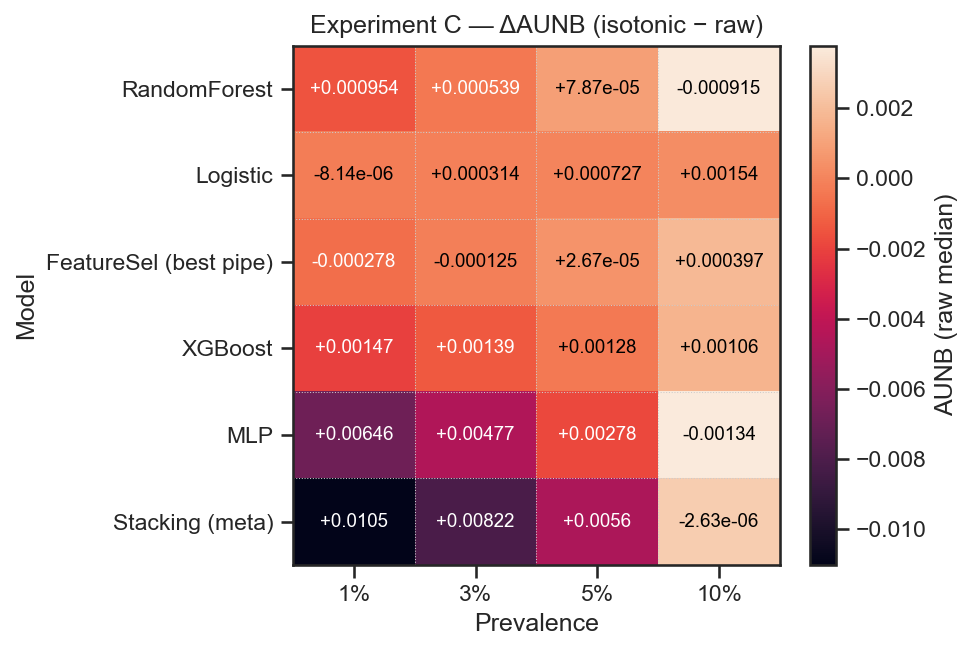

,0.01,0.03,0.05,0.10
RandomForest,0.0010,0.0005,0.0001,-0.0009
Logistic,-0.0000,0.0003,0.0007,0.0015
FeatureSel (best pipe),-0.0003,-0.0001,0.0000,0.0004
XGBoost,0.0015,0.0014,0.0013,0.0011
MLP,0.0065,0.0048,0.0028,-0.0013
Stacking (meta),0.0105,0.0082,0.0056,-0.0000


In [33]:
# === 2D heatmap of ΔAUNB (isotonic − raw), numbers in each cell, no arrows ===
from matplotlib import cm
def plot_aunb_heatmap(
    aunb_raw_dict,
    aunb_iso_dict,
    title="Experiment C — ΔAUNB (iso − raw)",
    outfile=None,
    model_order=None,
    background="raw",      # "raw" or "iso" heatmap background
    values="delta",        # numbers shown in cells: "delta" | "raw" | "iso"
    fmt_delta="+.3g",      # format for delta numbers
    fmt_bg=".3g"           # format for raw/iso numbers
):
    """Prevalence × model heatmap. Numbers per cell. No arrows."""

    # --- normalize prevalence keys (accept 0.05, 5, "5%") ---
    def _to_float_prev(k):
        if isinstance(k, (int, float, np.integer, np.floating)):
            v = float(k); return v/100.0 if v > 1.0 else v
        v = float(str(k).strip().replace("%",""))
        return v/100.0 if v > 1.0 else v

    def _as_label(p): return f"{int(round(p*100))}%"

    def _standardize(d):
        out = {}
        for k, df in d.items():
            p = _to_float_prev(k)
            if df is None or df.empty:
                continue
            cols = {c.lower(): c for c in df.columns}
            if "model" not in cols or "median" not in cols:
                raise ValueError("Each AUNB table must have columns 'Model' and 'median'.")
            out[p] = (df[[cols["model"], cols["median"]]]
                        .rename(columns={cols["model"]: "Model", cols["median"]: "median"})
                        .dropna())
        return out

    raw = _standardize(aunb_raw_dict)
    iso = _standardize(aunb_iso_dict)
    prevalences = sorted(set(raw) | set(iso))
    if not prevalences:
        raise ValueError("No prevalences found. Run Experiment C first.")

    models = sorted(
        set().union(*[set(df["Model"]) for df in raw.values()] if raw else [set()],
                    *[set(df["Model"]) for df in iso.values()] if iso else [set()])
    )
    if not models:
        raise ValueError("No models found in AUNB tables.")

    if model_order:
        models = [m for m in model_order if m in models] + [m for m in models if m not in (model_order or [])]

    # matrices (rows=models, cols=prevalences)
    R = pd.DataFrame(index=models, columns=prevalences, dtype=float)
    I = pd.DataFrame(index=models, columns=prevalences, dtype=float)

    for p in prevalences:
        if p in raw:
            R[p] = raw[p].set_index("Model")["median"].reindex(models).astype(float)
        if p in iso:
            I[p] = iso[p].set_index("Model")["median"].reindex(models).astype(float)

    D = I - R
    B = I if background == "iso" else R  # heatmap background matrix
    V = {"delta": D, "raw": R, "iso": I}[values]  # numbers to print

    # --- plotting ---
    fig, ax = plt.subplots(figsize=(max(6.5, 0.75*len(prevalences)+1),
                                    max(4.5, 0.45*len(models)+1)))

    im = ax.imshow(B.values, aspect="auto", interpolation="nearest")
    ax.set_xticks(np.arange(len(prevalences)))
    ax.set_yticks(np.arange(len(models)))
    ax.set_xticklabels([_as_label(p) for p in prevalences])
    ax.set_yticklabels(models)
    ax.set_xlabel("Prevalence")
    ax.set_ylabel("Model")
    ax.set_title(title)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f"AUNB ({'iso' if background=='iso' else 'raw'} median)")

    # numbers in cells with auto-contrast
    vmin = np.nanmin(B.values) if np.isfinite(B.values).any() else 0.0
    vmax = np.nanmax(B.values) if np.isfinite(B.values).any() else 1.0
    cmap = im.get_cmap() if hasattr(im, "get_cmap") else cm.get_cmap()

    def _text_color(bval):
        if not np.isfinite(bval) or vmax == vmin:
            return "black"
        t = (bval - vmin) / (vmax - vmin + 1e-12)
        r, g, b, _ = cmap(t)
        # perceived luminance
        L = 0.299*r + 0.587*g + 0.114*b
        return "black" if L > 0.6 else "white"

    n_rows, n_cols = B.shape
    for r in range(n_rows):
        for c in range(n_cols):
            val_print = V.iat[r, c]
            bg_val = B.iat[r, c]
            if not np.isfinite(val_print):
                continue
            txt = format(val_print, fmt_delta if values == "delta" else fmt_bg)
            ax.text(c, r, txt, ha="center", va="center",
                    fontsize=9, color=_text_color(bg_val))

    # grid
    ax.set_xticks(np.arange(-0.5, len(prevalences), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(models), 1), minor=True)
    ax.grid(which="minor", linestyle=":", linewidth=0.5)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.tight_layout()

    # safe save
    if outfile:
        outpath = Path(outfile)
        try:
            outdir = outpath.parent
            if str(outdir) in {"", ".", None}:
                outdir = Path("./results")
            outdir.mkdir(parents=True, exist_ok=True)
            plt.savefig(outdir / outpath.name, dpi=300, bbox_inches="tight")
            print("Saved figure to:", outdir / outpath.name)
        except Exception as e:
            print(f"[warn] Could not save to {outfile} ({e}). Showing only.")
    plt.show()
    return D

# -------- Build inputs from EXP_C and plot --------
assert "EXP_C" in globals() and isinstance(EXP_C, dict), "Run Experiment C first."

aunb_raw_dict = {}
aunb_iso_dict  = {}
for prev, pack in EXP_C.items():
    df_r = pack.get("aunb_raw", pd.DataFrame())
    df_i = pack.get("aunb_iso", pd.DataFrame())
    if not df_r.empty:
        aunb_raw_dict[prev] = df_r[["Model","median"]]
    if not df_i.empty:
        aunb_iso_dict[prev] = df_i[["Model","median"]]

preferred_order = [
    "RandomForest", "Logistic", "FeatureSel (best pipe)",
    "XGBoost", "MLP", "Stacking (meta)"
]

D = plot_aunb_heatmap(
        aunb_raw_dict,
        aunb_iso_dict,
        title="Experiment C — ΔAUNB (isotonic − raw)",
        outfile=Path("./results/aunb_delta_heatmap.png"),
        model_order=preferred_order,
        background="raw",   # heatmap shows raw AUNB
        values="delta"      # numbers are ΔAUNB (iso − raw)
)

display(pd.DataFrame(D).round(4))

#### Experiment D — Alarm-load frontier (FP per 1000 wafers vs Recall)

Saved figure to: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/alarm_frontier.png


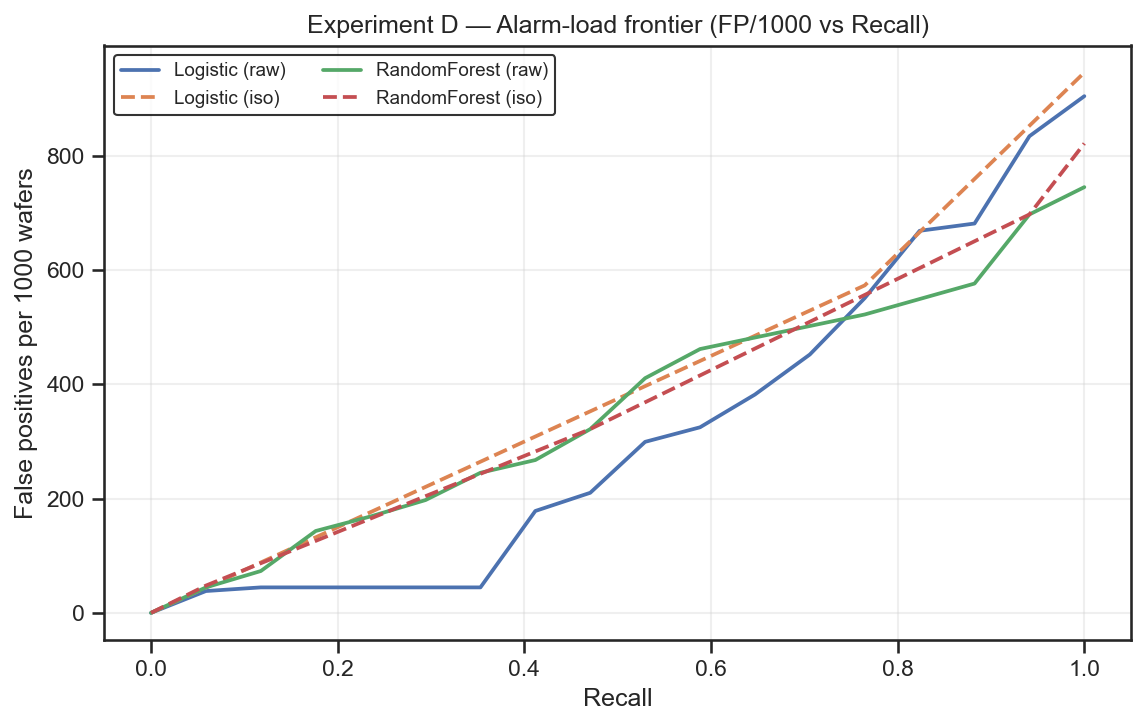

In [34]:
# === Experiment D — Alarm-load frontier (FP per 1000 wafers vs Recall) ===

# Helpers
def fp_per_1000(y, pred):
    """False positives per 1000 wafers."""
    y = np.asarray(y, int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    N = len(y)
    return 1000.0 * (fp / N)

def curve_fp1000_vs_recall(y, p, strategy="pr_thresholds"):
    """
    Return arrays (recall, fp_per_1000) by sweeping thresholds.
    strategy:
      - 'pr_thresholds': use PR-curve thresholds (recommended)
      - 'linspace': uniform thresholds in [0,1]
    """
    y = np.asarray(y, int); p = np.asarray(p, float)
    if strategy == "pr_thresholds":
        P, R, T = precision_recall_curve(y, p)
        thr = np.r_[T, 1.0]  # align to length of R
    else:
        thr = np.linspace(0.0, 1.0, 501)
        # compute recall separately below

    rec_list, fp1k_list = [], []
    for t in thr:
        pred = (p >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        rec_list.append(rec)
        fp1k_list.append(1000.0 * fp / len(y))
    r = np.asarray(rec_list, float)
    f = np.asarray(fp1k_list, float)

    # keep Pareto frontier: for each recall keep min FP/1000
    # bin by recall to smooth jagged duplicates
    bins = np.linspace(0, 1, 201)
    idx = np.digitize(r, bins, right=True)
    best = {}
    for i, b in enumerate(idx):
        if b not in best or f[i] < best[b][1]:
            best[b] = (r[i], f[i])
    out = np.array(sorted(best.values(), key=lambda x: x[0]))
    return out[:,0], out[:,1]

def plot_alarm_frontier(models=("Logistic","RandomForest"),
                        calibrated_modes=("raw","iso"),
                        title="Experiment D — Alarm-load frontier (FP/1000 vs Recall)",
                        outfile=RESULT_DIR/"alarm_frontier.png"):
    plt.figure(figsize=(7.8, 5.0))
    styles = {("raw"): "-", ("iso"): "--"}
    for m in models:
        for cal in calibrated_modes:
            p = get_probs(m, split="test", calibrated=cal)
            if p is None: 
                continue
            r, f = curve_fp1000_vs_recall(yte, p, strategy="pr_thresholds")
            lbl = f"{m} ({cal})"
            plt.plot(r, f, styles[cal], lw=1.8, label=lbl)
    plt.xlabel("Recall")
    plt.ylabel("False positives per 1000 wafers")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2, fontsize=9)
    plt.tight_layout()
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    print("Saved figure to:", outfile)
    plt.show()

plot_alarm_frontier()

In [35]:
# Optional: numeric summary at target recall levels
TARGET_RECALL = [0.10, 0.20, 0.30]

def nearest_fp1k_at_recall(y, p, r_target):
    r, f = curve_fp1000_vs_recall(y, p)
    if len(r) == 0: 
        return np.nan
    j = int(np.argmin(np.abs(r - r_target)))
    return float(f[j])

rows = []
for m in ("Logistic","RandomForest"):
    for cal in ("raw","iso"):
        p = get_probs(m, split="test", calibrated=cal)
        if p is None: 
            continue
        for rt in TARGET_RECALL:
            fp1k = nearest_fp1k_at_recall(yte, p, rt)
            rows.append({"Model": m, "Calib": cal, "Recall_target": rt, "FP_per_1000": fp1k})

df_frontier = pd.DataFrame(rows)
# wide view with delta (iso - raw)
wide = (df_frontier
        .pivot_table(index=["Model","Recall_target"], columns="Calib", values="FP_per_1000")
        .reindex(columns=["raw","iso"]))
wide["ΔFP/1000 (iso-raw)"] = wide["iso"] - wide["raw"]
display(wide.round(2))

Calib                          raw     iso  ΔFP/1000 (iso-raw)
Model        Recall_target                                    
Logistic     0.1             44.59    0.00              -44.59
             0.2             44.59    0.00              -44.59
             0.3             44.59    0.00              -44.59
RandomForest 0.1             73.25   47.77              -25.48
             0.2            143.31   47.77              -95.54
             0.3            197.45  321.66              124.20

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/04_alarm_frontier_Logistic.png


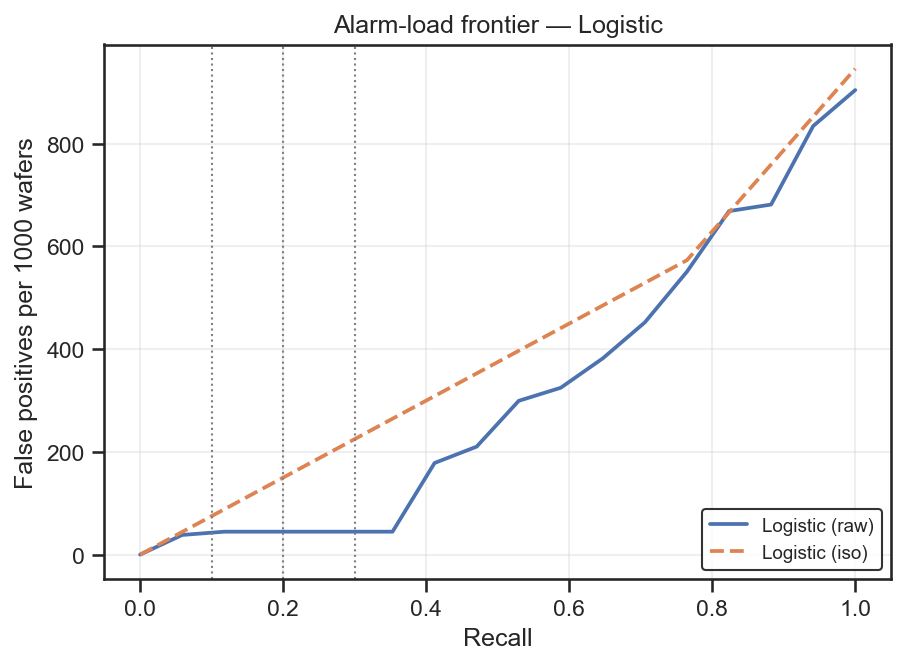

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/04_alarm_frontier_RandomForest.png


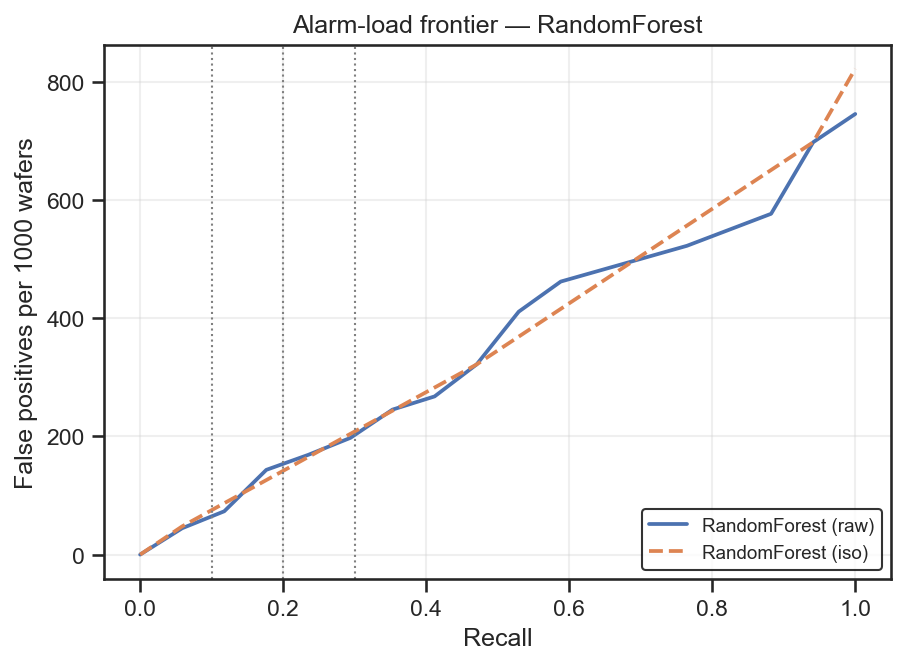

In [36]:
# Optional: per-model overlay plots for report
def plot_per_model_frontier(model):
    plt.figure(figsize=(6.2, 4.6))
    for cal, style in (("raw","-"), ("iso","--")):
        p = get_probs(model, split="test", calibrated=cal)
        if p is None: 
            continue
        r, f = curve_fp1000_vs_recall(yte, p)
        plt.plot(r, f, style, lw=1.8, label=f"{model} ({cal})")
    for rt in TARGET_RECALL:
        plt.axvline(rt, ls=":", color="gray", lw=1)  # guide
    plt.xlabel("Recall"); plt.ylabel("False positives per 1000 wafers")
    plt.title(f"Alarm-load frontier — {model}")
    plt.grid(True, alpha=0.3); plt.legend(fontsize=9)
    plt.tight_layout()
    savefig(f"04_alarm_frontier_{model}.png")
    plt.show()

for m in ("Logistic","RandomForest"):
    plot_per_model_frontier(m)

Saved: /Volumes/MyProjects/GitHub/DataScience/Project3-SECOMSemiconductorYieldPrediction/results/advanced_research/05_executive_digest.png


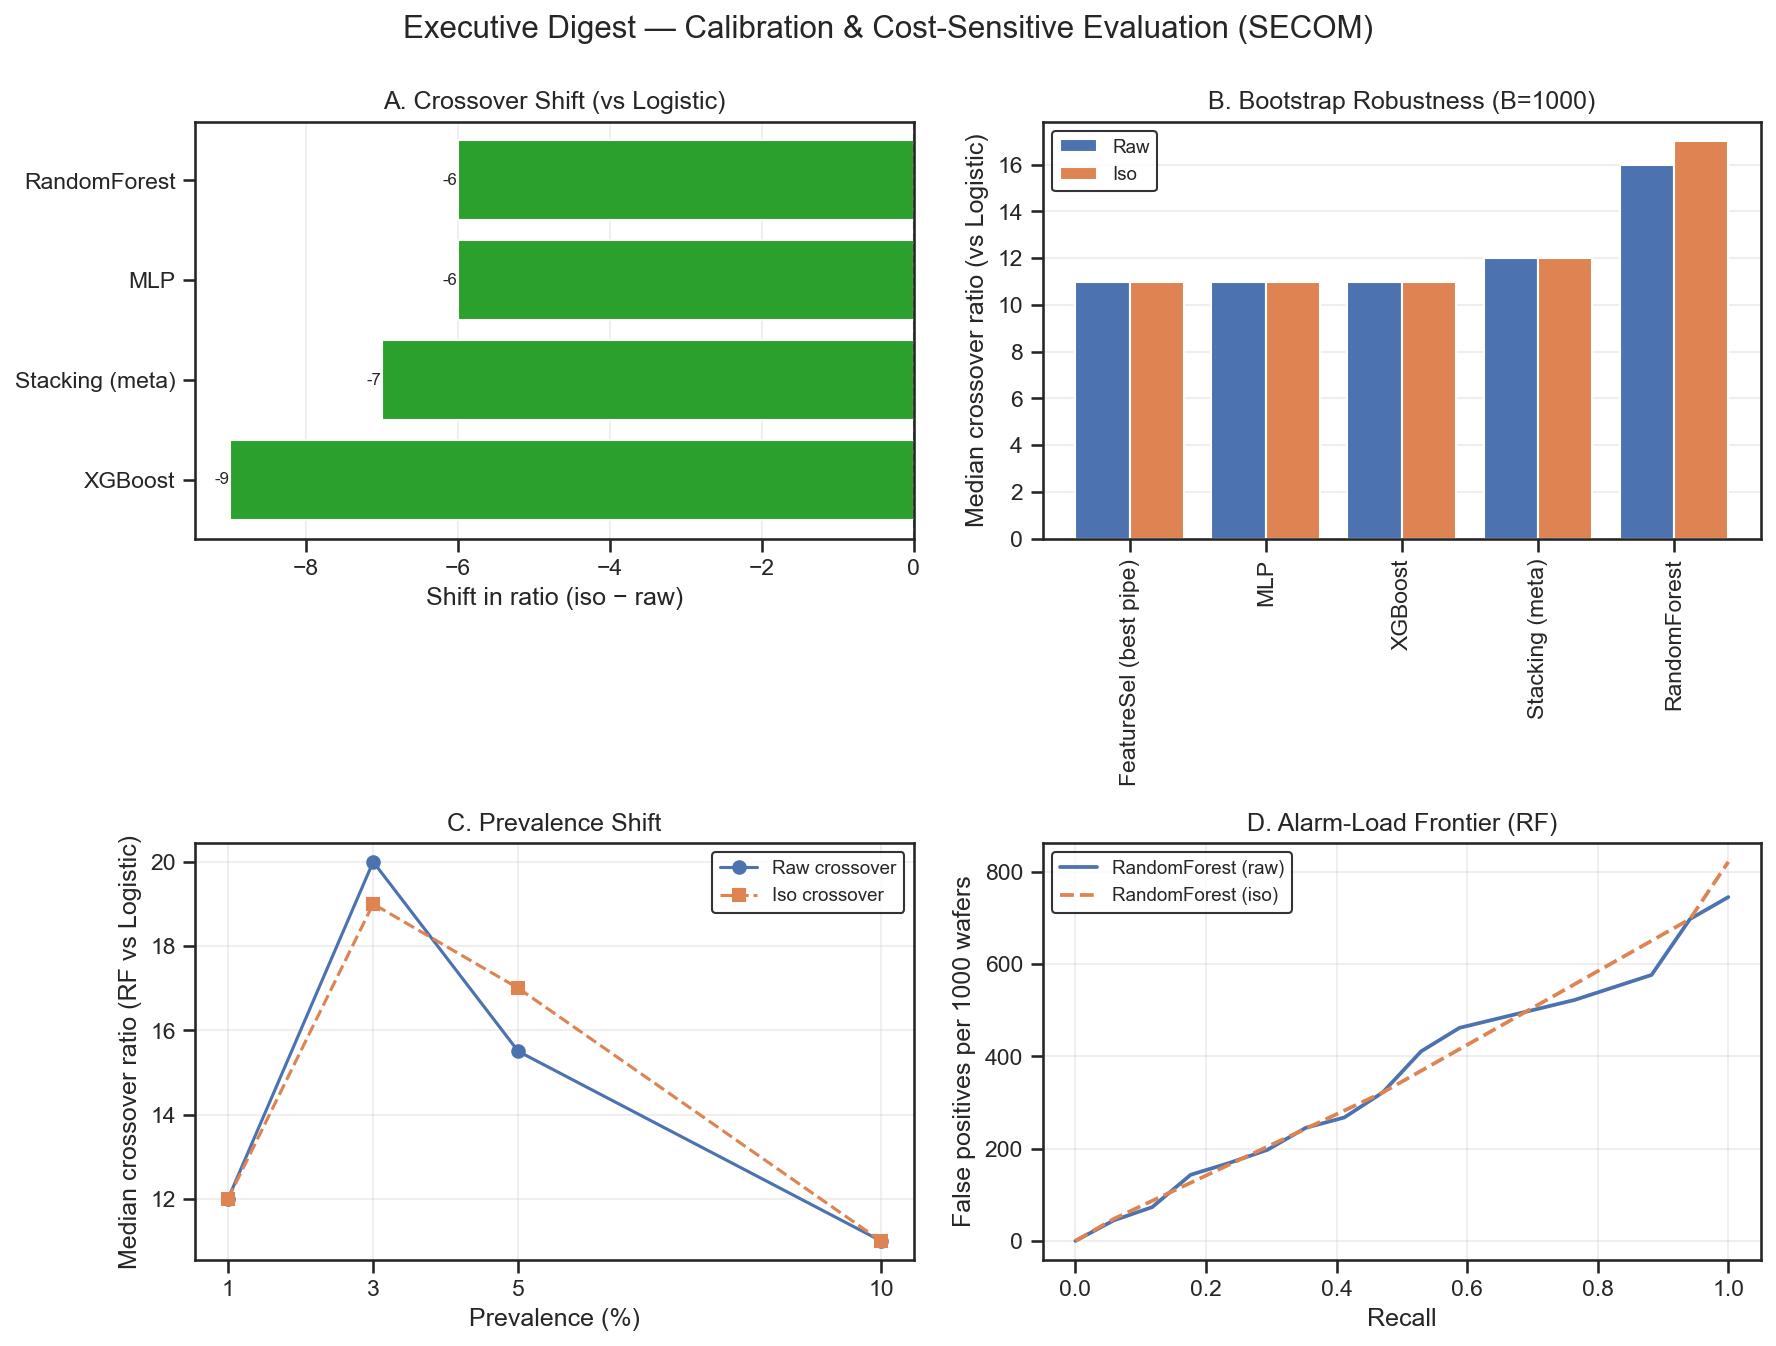

In [37]:
# === Executive Digest (A–D) — Fully data-driven ===
# Requirements (from your notebook):
# - Experiment A table:        `tab` with columns ["Model","Raw_crossover","Iso_crossover","Shift_in_ratio"]
# - Experiment B summaries:    `summaries` dict keyed by B with 'xover_raw'/'xover_iso' (Median per Model)
# - Experiment C prevalence:   `EXP_C` dict with per-prev 'xover_raw'/'xover_iso' (Median per Model)
# - Experiment D helpers:      `curve_fp1000_vs_recall`, `get_probs`, `yte`
# - Paths:                     `RESULT_DIR`

# -------- Panel A: Crossover shift (iso − raw) vs Logistic, from Experiment A `tab`
def panel_A(ax):
    if 'tab' not in globals() or tab is None or tab.empty:
        ax.text(0.5, 0.5, "Experiment A results not found", ha="center", va="center")
        ax.axis("off"); return

    dfA = tab.copy()
    # Numeric shifts only
    df_num = dfA[pd.to_numeric(dfA["Shift_in_ratio"], errors="coerce").notna()].copy()
    df_num["Shift_in_ratio"] = df_num["Shift_in_ratio"].astype(float)
    if df_num.empty:
        ax.text(0.5, 0.5, "No numeric crossovers to display", ha="center", va="center")
        ax.axis("off"); return

    df_num = df_num.sort_values("Shift_in_ratio")
    colors = np.where(df_num["Shift_in_ratio"] < 0, "tab:green", "tab:red")
    ax.barh(df_num["Model"], df_num["Shift_in_ratio"], color=colors)
    ax.axvline(0, color="gray", ls="--", lw=1)
    ax.set_xlabel("Shift in ratio (iso − raw)"); ax.set_title("A. Crossover Shift (vs Logistic)")
    ax.grid(True, axis="x", alpha=0.3)

    # Optional annotations
    for y, v in enumerate(df_num["Shift_in_ratio"].to_numpy()):
        ax.text(v, y, f"{v:+.0f}", va="center",
                ha="left" if v>=0 else "right", fontsize=8)

# -------- Panel B: Bootstrap robustness — median crossover ratio (vs Logistic), from `summaries`
def panel_B(ax):
    if 'summaries' not in globals() or not isinstance(summaries, dict) or not summaries:
        ax.text(0.5, 0.5, "Experiment B summaries not found", ha="center", va="center")
        ax.axis("off"); return

    # pick the largest B that exists
    B_pick = max(summaries.keys())
    sx = summaries[B_pick]
    xr = sx.get("xover_raw", pd.DataFrame())
    xi = sx.get("xover_iso", pd.DataFrame())
    if xr is None or xi is None or xr.empty or xi.empty:
        ax.text(0.5, 0.5, "Missing xover medians", ha="center", va="center")
        ax.axis("off"); return

    # Merge medians for models present in either; drop Logistic and non-numeric
    def clean(df):
        d = df.copy()
        d = d[pd.to_numeric(d["Median"], errors="coerce").notna()]
        d["Median"] = d["Median"].astype(float)
        return d[~d["Model"].str.contains("^Logistic$", case=False, na=False)]

    xr = clean(xr).rename(columns={"Median":"Raw"})
    xi = clean(xi).rename(columns={"Median":"Iso"})
    m = pd.merge(xr[["Model","Raw"]], xi[["Model","Iso"]], on="Model", how="outer").dropna()

    if m.empty:
        ax.text(0.5, 0.5, "No common models with medians", ha="center", va="center")
        ax.axis("off"); return

    m = m.sort_values("Raw")
    x = np.arange(len(m))
    ax.bar(x-0.2, m["Raw"], width=0.4, label="Raw")
    ax.bar(x+0.2, m["Iso"], width=0.4, label="Iso")
    ax.set_xticks(x); ax.set_xticklabels(m["Model"], rotation=90)
    ax.set_ylabel("Median crossover ratio (vs Logistic)")
    ax.set_title(f"B. Bootstrap Robustness (B={B_pick})")
    ax.grid(True, axis="y", alpha=0.3)
    ax.legend(fontsize=9)

# -------- Panel C: Prevalence shift — RF vs Logistic median crossover across prevalences, from `EXP_C`
def panel_C(ax):
    if 'EXP_C' not in globals() or not isinstance(EXP_C, dict) or not EXP_C:
        ax.text(0.5, 0.5, "Experiment C results not found", ha="center", va="center")
        ax.axis("off"); return

    prevs = []
    rf_raw = []
    rf_iso = []
    for prev, pack in sorted(EXP_C.items(), key=lambda kv: float(kv[0])):
        xr = pack.get("xover_raw", pd.DataFrame())
        xi = pack.get("xover_iso", pd.DataFrame())
        def get_med(df, model="RandomForest"):
            if df is None or df.empty: return np.nan
            d = df[df["Model"].str.contains("^RandomForest$", case=False, na=False)]
            if d.empty: return np.nan
            v = pd.to_numeric(d["Median"], errors="coerce")
            return float(v.iloc[0]) if v.notna().any() else np.nan
        r_raw = get_med(xr); r_iso = get_med(xi)
        if np.isfinite(r_raw) and np.isfinite(r_iso):
            prevs.append(float(prev)*100 if float(prev)<=1 else float(prev))
            rf_raw.append(r_raw); rf_iso.append(r_iso)

    if not prevs:
        ax.text(0.5, 0.5, "No RF crossover medians across prevalences", ha="center", va="center")
        ax.axis("off"); return

    ax.plot(prevs, rf_raw, "o-", label="Raw crossover")
    ax.plot(prevs, rf_iso, "s--", label="Iso crossover")
    ax.set_xticks(prevs); ax.set_xlabel("Prevalence (%)")
    ax.set_ylabel("Median crossover ratio (RF vs Logistic)")
    ax.set_title("C. Prevalence Shift")
    ax.grid(True, alpha=0.3); ax.legend(fontsize=9)

# -------- Panel D: Alarm-load frontier — FP/1000 vs Recall for RF (raw vs iso), recomputed from probs
def panel_D(ax):
    # Needs Experiment D helpers
    missing = []
    for name in ["curve_fp1000_vs_recall", "get_probs", "yte"]:
        if name not in globals():
            missing.append(name)
    if missing:
        ax.text(0.5, 0.5, f"Missing: {', '.join(missing)}", ha="center", va="center")
        ax.axis("off"); return

    curves = {}
    for cal, style in (("raw","-"), ("iso","--")):
        p = get_probs("RandomForest", split="test", calibrated=cal)
        if p is None:
            continue
        r, f = curve_fp1000_vs_recall(yte, p, strategy="pr_thresholds")
        curves[cal] = (r, f)
        ax.plot(r, f, style, lw=1.8, label=f"RandomForest ({cal})")

    if not curves:
        ax.text(0.5, 0.5, "No RF curves available", ha="center", va="center")
        ax.axis("off"); return

    ax.set_xlabel("Recall")
    ax.set_ylabel("False positives per 1000 wafers")
    ax.set_title("D. Alarm-Load Frontier (RF)")
    ax.grid(True, alpha=0.3); ax.legend(fontsize=9)

# -------- Compose and save
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
panel_A(axes[0,0])
panel_B(axes[0,1])
panel_C(axes[1,0])
panel_D(axes[1,1])

plt.suptitle("Executive Digest — Calibration & Cost-Sensitive Evaluation (SECOM)", fontsize=15, y=0.995)
plt.tight_layout(rect=[0,0,1,0.97])
savefig("05_executive_digest.png")
plt.show()